## Cross section dimension sweep

In [64]:
# standard python imports
import numpy as np
import matplotlib.pylab as plt
plt.figure(figsize = (12, 6))

#specialty numpy imports
import scipy.integrate as integrate
from scipy.optimize import fsolve

# tidy3D import
import tidy3d as td
from tidy3d.constants import C_0
from tidy3d.plugins import waveguide
import tidy3d.web as web
from tidy3d.plugins.mode.web import run as run_mode_solver
from tidy3d.plugins.mode import ModeSolver
import gdstk

<Figure size 1200x600 with 0 Axes>

In [186]:
# size of simulation domain
Lx, Ly, Lz = 4, 4, 4 #region size (um)
dl = 0.01 #step size (um)
nm = 1e-3 #nanometer conversion nm to um

# device layer dimensions (um) & material properties
# device layer is BTO
mesa_thickness = 300 * nm
mesa_width = 1000 * nm
etch_depth = 100 * nm # etch depth is a fundamental tuning parameter
slab_thickness = mesa_thickness - etch_depth # adjustable slab thickness
device_no = 2.4 # ordinary index of refraction @ 1.55um
device_ne = 2.3 # extraordinary index of refraction @ 1.55um
device_xx = td.Medium(permittivity = device_no**2) # ordinary axis
device_yy = td.Medium(permittivity = device_no**2) # ordinary axis
device_zz = td.Medium(permittivity = device_ne**2) # extraordinary axis
device_mat = td.AnisotropicMedium(xx = device_xx, 
                                  yy = device_yy, 
                                  zz = device_zz,
                                 )

# buffer layer dimensions (um) & material properties
# buffer is STO
buffer_thickness = 10 * nm # convert nm to um
buffer_no = 2.4 # ordinary index of refraction @ 1.55um
buffer_ne = 2.3 # extraordinary index of refraction @ 1.55um
buffer_xx = td.Medium(permittivity = buffer_no**2) # ordinary axis
buffer_yy = td.Medium(permittivity = buffer_no**2) # ordinary axis
buffer_zz = td.Medium(permittivity = buffer_ne**2) # extraordinary axis
buffer_mat = td.AnisotropicMedium(xx = buffer_xx, 
                                  yy = buffer_yy, 
                                  zz = buffer_zz,
                                 )

# substrate layer dimenions (um) & material properties
# substrate is SiO2
sio2_thickness = 2.0
sio2 = td.material_library["SiO2"]["Horiba"]

# substrate layer dimenions (um) & material properties
# substrate is SiO2
si_thickness = 2*Lz
si = td.material_library["cSi"]["Li1993_293K"]

# central frequency & wavelength
wvl_um = 1.55
freq0 = C_0 / wvl_um
fwidth = freq0 / 3

# run_time in picoseconds
run_time = 1e-12

# automatic grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl_um)

16:01:42 UTC WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

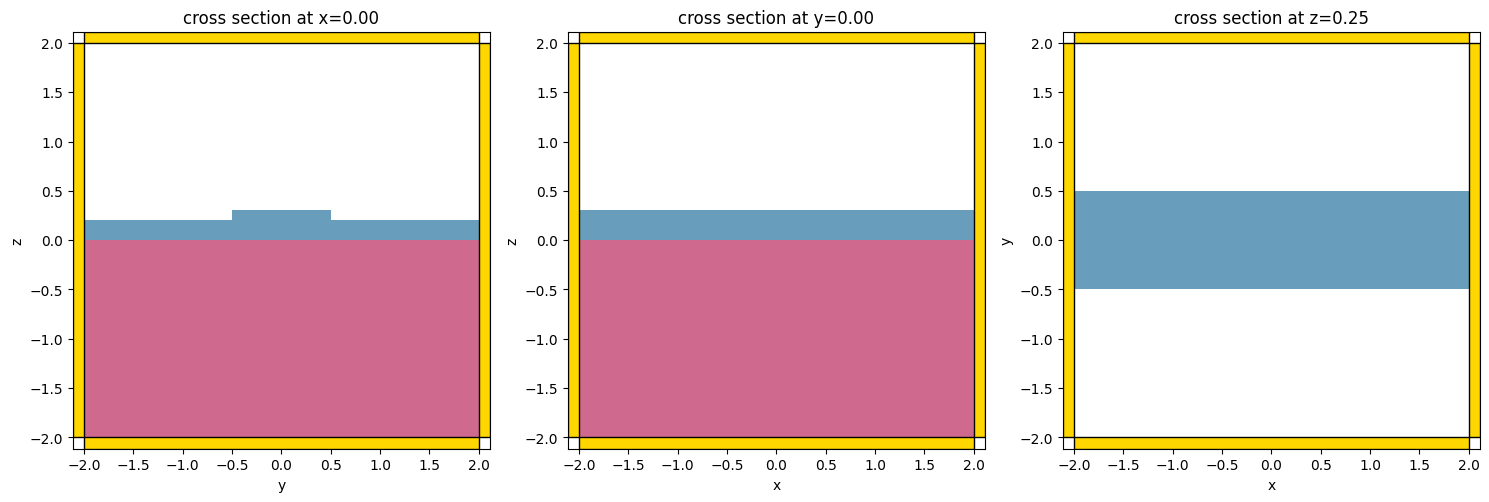

In [187]:
#BTO mesa
mesa = td.Structure(
    geometry = td.Box(size = (td.inf, mesa_width, mesa_thickness), 
                    center = (0, 0, (mesa_thickness + buffer_thickness) / 2),
                   ),
    medium = device_mat,
)

#BTO Slab
slab = td.Structure(
    geometry = td.Box(size = (td.inf, td.inf, slab_thickness),
                    center = (0,0, (slab_thickness + buffer_thickness) / 2),
                   ),
    medium = device_mat,
)

#STO Buffer
buffer_layer = td.Structure(
    geometry = td.Box(size = (td.inf, td.inf, buffer_thickness),
                    center = (0, 0, buffer_thickness / 2),
                   ),
    medium = buffer_mat,
)

#SiO2 substrate
sio2_sub = td.Structure(
    geometry = td.Box(size=(td.inf, td.inf, sio2_thickness),
                    center = (0, 0, -sio2_thickness / 2),
                   ),
    medium = sio2,
)

#Si substrate
si_sub = td.Structure(
    geometry = td.Box(size=(td.inf, td.inf, si_thickness),
                    center = (0, 0, -si_thickness / 2 - sio2_thickness),
                   ),
    medium = si,
)

#create simulation region
mode_cross_section_sim = td.Simulation(
    size = (Lx, Ly, Lz),
    grid_spec = grid_spec,
    structures = [mesa, slab, buffer_layer, sio2_sub, si_sub],
    run_time = run_time,
    boundary_spec = td.BoundarySpec.all_sides(boundary = td.PECBoundary()),
)

#plot waveguide in third angle ortho projection 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 6))
mode_cross_section_sim.plot(x=0, ax=ax1)
mode_cross_section_sim.plot(y=0, ax=ax2)
mode_cross_section_sim.plot(z=0.25, ax=ax3)
plt.show()

In [188]:
mode_plane = td.Box(center = (0, 0, 0), size = (0, Ly, Lz)) #define monitor plane

# create mode monitor specifications
# can find as many modes as is necessary 
num_modes = 20
mode_spec = td.ModeSpec(
    num_modes = num_modes,
    target_neff = device_no,
)

# define the mode calculation 
cross_section_mode_solver = ModeSolver(
    simulation = mode_cross_section_sim,
    plane = mode_plane,
    mode_spec = mode_spec,
    freqs = freq0,
)

# calculate modes 
# local solver
mode_data = cross_section_mode_solver.solve()

# web solver. use this if the mode solver 
# is crashing for intensive calcs
#mode_data = run_mode_solver(cross_section_mode_solver)

# print mode data
mode_data.to_dataframe()

16:01:48 UTC WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 2 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 3 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 4 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 5 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 6 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 8 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 9 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 11 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 12 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 13 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 15 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 16 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 19 does not   
             decay at the plane boundaries.                                     

wavelength     n eff     k eff  loss (dB/cm)  \
f            mode_index                                                 
1.934145e+14 0                 1.55  1.907966  0.000028      9.740137   
             1                 1.55  1.787574  0.000046     16.067772   
             2                 1.55  1.771798  0.000048     16.964448   
             3                 1.55  1.732678  0.000045     15.688259   
             4                 1.55  1.652789  0.000049     17.367768   
             5                 1.55  1.569286  0.000077     27.053386   
             6                 1.55  1.563657  0.000227     79.989451   
             7                 1.55  1.538148  0.000132     46.468048   
             8                 1.55  1.528134  0.000240     84.639725   
             9                 1.55  1.466830  0.000250     88.171673   
             10                1.55  1.443154  0.000147     51.752442   
             11                1.55  1.418464  0.000108     38.007449   
             12                1.55  1.408098  0.000211     74.162154   
             13                1.55  1.394958  0.000222     78.196782   
             14                1.55  1.391696  0.000201     70.780648   
             15                1.55  1.376496  0.000267     93.933652   
             16                1.55  1.356295  0.000228     80.247362   
             17                1.55  1.329104  0.000225     79.380919   
             18                1.55  1.304972  0.000207     72.818496   
             19                1.55  1.286760  0.000237     83.389500   

                         TE (Ey) fraction  wg TE fraction  wg TM fraction  \
f            mode_index                                                     
1.934145e+14 0                   0.995271        0.954040        0.817564   
             1                   0.994989        0.979766        0.796540   
             2                   0.999974        0.976957        0.793739   
             3                   0.986583        0.896110        0.817450   
             4                   0.997753        0.838938        0.826180   
             5                   0.689758        0.754768        0.872633   
             6                   0.033607        0.861400        0.974605   
             7                   0.174641        0.769540        0.931586   
             8                   0.008884        0.873832        0.942052   
             9                   0.019762        0.883615        0.869544   
             10                  0.198050        0.817197        0.899623   
             11                  0.660534        0.730846        0.887168   
             12                  0.969708        0.975523        0.924671   
             13                  0.992972        0.982877        0.927521   
             14                  0.021085        0.881346        0.895387   
             15                  0.034562        0.897612        0.767613   
             16                  0.993647        0.918207        0.938985   
             17                  0.009560        0.813106        0.946054   
             18                  0.093719        0.867829        0.782310   
             19                  0.998591        0.821875        0.940821   

                         mode area  
f            mode_index             
1.934145e+14 0            0.578589  
             1            1.717242  
             2            1.059515  
             3            1.375491  
             4            1.466717  
             5            2.219161  
             6            1.285188  
             7            1.497875  
             8            1.207373  
             9            1.222579  
             10           3.080395  
             11           3.190523  
             12           6.360183  
             13           3.841701  
             14           3.856004  
             15           1.246298  
             16           4.227957  
             17     

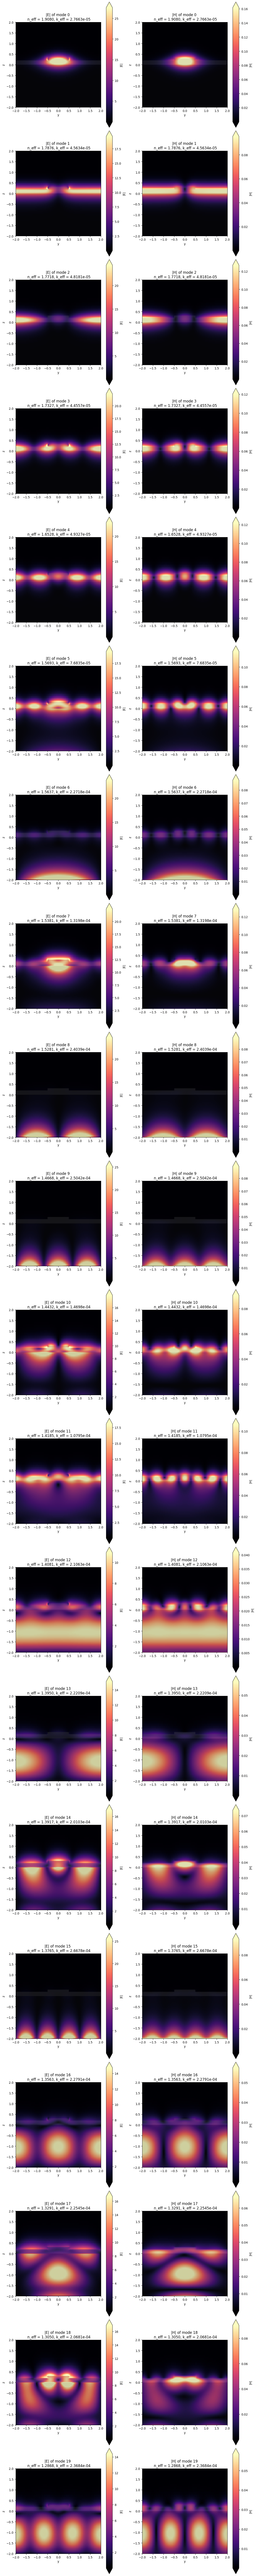

In [18]:
n_complex = mode_data.n_complex  # complex effective index as a DataArray
n_eff = mode_data.n_eff.values  # real part of the effective index as numpy array
k_eff = mode_data.k_eff.values  # imag part of the effective index as numpy array

#plot into subplots showing the magnetic and electric field
f, fields = plt.subplots(nrows = len(n_eff[0]), 
                         ncols = 2, 
                         tight_layout=True, 
                         figsize=(12, 6*len(n_eff[0])),
                        )

#define axis limits for the subplots 
xmin = -Lx/2
xmax = Lx/2
ymin = -Lz/2
ymax = Lz/2

for i in range(len(n_eff[0])):
    
    #define the subplots 
    cross_section_mode_solver.plot_field("E", "abs", mode_index=i, f=freq0, ax=fields[i,0])
    cross_section_mode_solver.plot_field("H", "abs", mode_index=i, f=freq0, ax=fields[i,1])
    
    #define subplot for electric field
    fields[i,0].set_title(f"|E| of mode {i} \n n_eff = {n_eff[0,i]:.4f}, k_eff = {k_eff[0,i]:.4e}")
    fields[i,0].set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    fields[i,0].set_aspect("equal")
    
    #define subplot for magnetic field
    fields[i,1].set_title(f"|H| of mode {i} \n n_eff = {n_eff[0,i]:.4f}, k_eff = {k_eff[0,i]:.4e}")
    fields[i,1].set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    fields[i,1].set_aspect("equal")
    
plt.savefig('mode_plots.png', bbox_inches='tight')
plt.show()

## Grating Optimization

In [190]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wavelength)

# waveguide
wg_width = 400 * nm
wg_height = 300 * nm
wg_length = 2 * wavelength

# surrounding
sio2_height = 2.0
air_height = 2.0
si_height = 40 * wavelength
buffer = 0.5 * wavelength #not the same as the STO buffer layer!

# coupler
cp_width = 6 * wavelength
cp_length = 10 * wavelength

# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = 4 * wavelength
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx / 2 - buffer - (wg_length + taper_length) / 2
cp_center_x = -Lx / 2 + buffer + cp_length / 2

# materials
Air = td.Medium(permittivity=1.0)

# source parameters
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth

# grating parameters
design_theta_deg = -8
design_theta_rad = np.pi * design_theta_deg / 180
grating_height = etch_depth

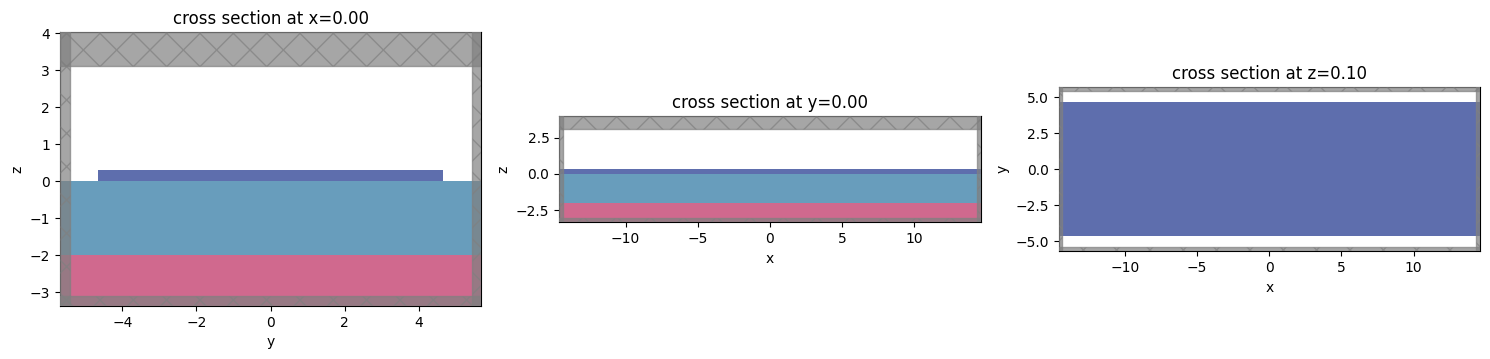

In [89]:
# do a mode solve to get neff of the coupler to determine the central diffraction pitch
# we will sweep around that pitch to determin the optimal pitch 
# central pitch is determined by using Laue Diffraction/Bragg Diffraction to determine
# first order diffraction and then relate it to the propagation constant inside the coupler

#build coupler film stack
coupler_sio2 = td.Structure(
    geometry=td.Box(center=[0, 0, -sio2_height / 2], 
                    size=[td.inf, td.inf, sio2_height],
                   ),
    medium=sio2,
    name="sio2 substrate",
)

coupler_si = td.Structure(
    geometry=td.Box(center=[0, 0, -sio2_height - si_height/2], 
                    size=[td.inf, td.inf, si_height],
                   ),
    medium=si,
    name="si substrate",
)

coupler_buffer = td.Structure(
    geometry=td.Box(
        center=[0, 0, buffer_thickness / 2],
        size=[td.inf, cp_width, buffer_thickness],
    ),
    medium=buffer_mat,
    name="coupler_buffer",
)

coupler_device = td.Structure(
    geometry=td.Box(
        center=[0, 0, wg_height/2 + buffer_thickness],
        size=[td.inf, cp_width, wg_height],
    ),
    medium=device_mat,
    name="coupler",
)

#make the plan to solve the modal projection 
mode_plane = td.Box(center=(0, 0, 0), size=(0, 8 * cp_width, 2 * wavelength))

#create simulation region and check the geometry is correct
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[coupler_sio2, coupler_si, coupler_buffer, coupler_device],
    sources=[],
    monitors=[],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    run_time=1e-12,
)

#view the geometry in third angle ortho projection 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 6))
sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=0.1, ax=ax3)
plt.show()

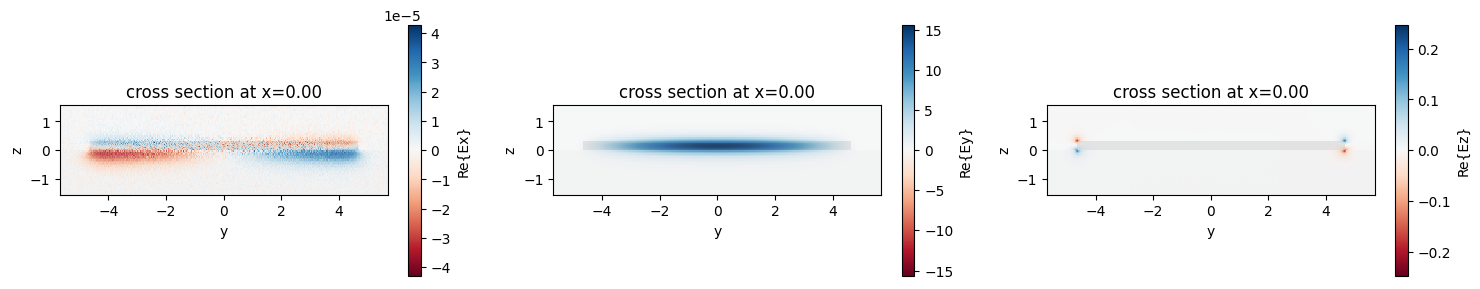

effective index inside bulk coupler = 2.0164


In [90]:
ms = ModeSolver(
    simulation=sim, plane=mode_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
ms.plot_field("Ex", val="real", robust=False, ax=ax1)
ms.plot_field("Ey", val="real", robust=False, ax=ax2)
ms.plot_field("Ez", val="real", robust=False, ax=ax3)
plt.show()

neff = float(mode_output.n_eff)
print(f"effective index inside bulk coupler = {neff:.4f}")

central pitch according to classical diffraction theory =  895.000000 nm


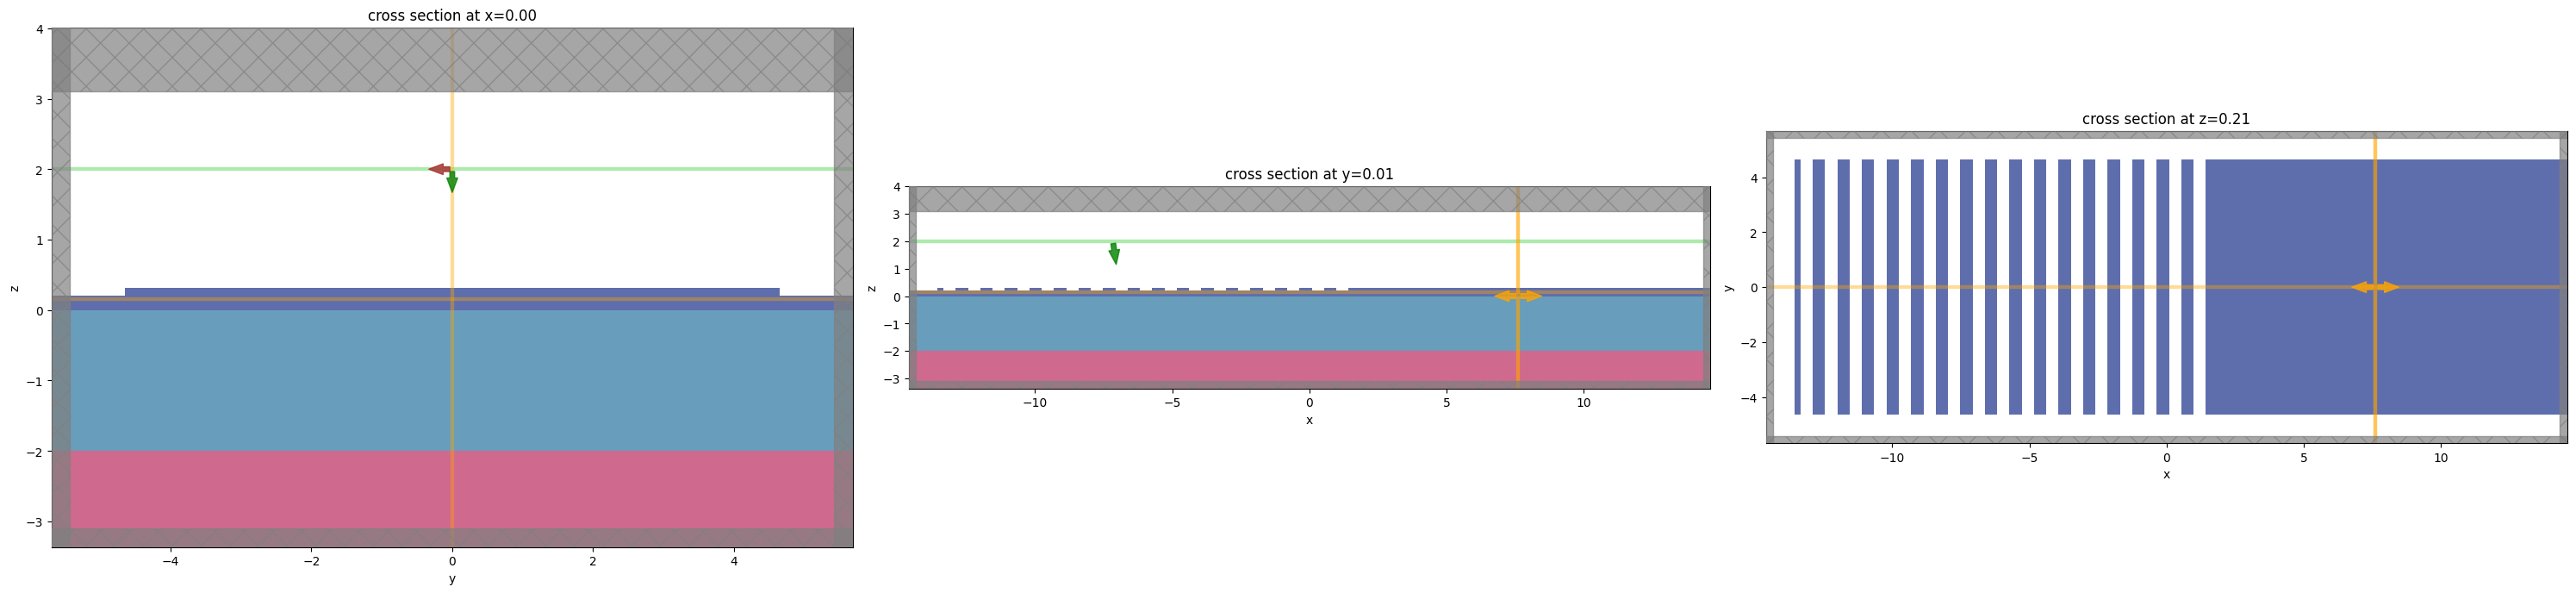

In [205]:
# determine initial pitch guess from diffraction formula 
#pitch_cen = wavelength / (neff - np.sin(abs(design_theta_rad))) #initial pitch guess
pitch_cen = 895 * nm
print(f"central pitch according to classical diffraction theory =  {pitch_cen/nm:4f} nm")
pitch_shift = 10 * nm #how far to the left AND right of central pitch to sweep
pitch_left = pitch_cen - pitch_shift
pitch_right = pitch_cen + pitch_shift
num_sweep = 20 # how many steps in the pitch sweep
pitch_sweep = np.linspace(pitch_left, pitch_right, num_sweep)

sio2_sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sio2_height/2],
        size=[td.inf, td.inf, sio2_height],
    ),
    medium=sio2,
    name="sio2 substrate"
)

si_sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sio2_height - si_height/2],
        size=[td.inf, td.inf, si_height],
    ),
    medium=si,
    name="si substrate"
)

wg = td.Structure(
    geometry=td.Box(
        center=[wg_center_x, 0, buffer_thickness + wg_height/2],
        size=[buffer + wg_length + taper_length + cp_length / 2, cp_width, wg_height],
    ),
    medium=device_mat,
    name="waveguide"
)

wg_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, buffer_thickness + slab_thickness/2],
        size=[td.inf, td.inf, slab_thickness],
    ),
    medium=device_mat,
    name="waveguide slab"
)

wg_buffer = td.Structure(
    geometry=td.Box(
        center=[0, 0, buffer_thickness / 2],
        size=[td.inf, td.inf, buffer_thickness],
    ),
    medium=buffer_mat,
    name="waveguide buffer"
)

cp = td.Structure(
    geometry=td.Box(
        center=[cp_center_x, 0, buffer_thickness + wg_height/2],
        size=[cp_length, cp_width, wg_height],
    ),
    medium=device_mat,
    name="coupler"
)

def make_pitch_sim(pitch):
    
    grating_length = pitch / 2.0 #assumes fill factor of 0.5
    num_gratings = int(cp_length / pitch) 

    #create the gratings
    grating_left_x = cp_center_x - cp_length / 2
    gratings = [
        td.Structure(
            geometry=td.Box(
                center=[
                    grating_left_x + (i + 0.5) * pitch,
                    0,
                    wg_height + buffer_thickness,
                ],
                size=[grating_length, cp_width, 2*grating_height],
            ),
            medium=Air,
            name=f"{i}th_grating"
        )
        for i in range(num_gratings)
    ]

    #gaussian input 
    gaussian_beam = td.GaussianBeam(
        size=(td.inf, td.inf, 0),
        center=[-(num_gratings-1)*pitch/2, 0, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        angle_theta= np.abs(design_theta_rad),
        angle_phi=np.pi,
        direction="-",
        waist_radius=2,
        pol_angle=np.pi / 2
    )
    
    plane_monitor = td.FieldMonitor(
    center=[0, 0, wg_height / 2],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="full_domain_fields"
    )

    rad_monitor = td.FieldMonitor(
        center=[0, 0, 0], 
        size=[td.inf, 0, td.inf], freqs=[freq0], 
        name="radiated_fields"
    )
    
    mode_mon = td.ModeMonitor(
        center=(num_gratings*pitch_cen/2,0,0),
        size=(0,td.inf,td.inf),
        freqs=[freq0],
        mode_spec = mode_spec,
        name='mode_monitor'
    )

    flux_mon = td.FluxMonitor(
        size=mode_mon.size,
        center=mode_mon.center,
        freqs=[freq0],
        name="flux"
    )

    #create the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[sio2_sub, si_sub, wg_buffer, cp, wg_slab, wg] + gratings,
        sources=[gaussian_beam],
        monitors=[plane_monitor, rad_monitor, mode_mon, flux_mon],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
    )

    return sim

#make a simulation object to test the functions works
sim_test = make_pitch_sim(pitch_cen)

#plot the simulation to verify the geometry
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(30, 30))
sim_test.plot(x=0, ax=ax1)
sim_test.plot(y=0.01, ax=ax2)
sim_test.plot(z=0.21, ax=ax3)
plt.show()

In [177]:
# submit all jobs
# estimate cost first!!
'''
pitch_sims = {f"p={p:.3f}": make_pitch_sim(p) for p in pitch_sweep}
batch_pitch = web.Batch(simulations=pitch_sims, verbose=True)
#estimate_batch_cost = estimate_cost = web.estimate_cost(task_id)
grating_batch_results = batch_pitch.run(path_dir="data")
'''
# if needing to disconnect from jupyter server use this code block 
# to save the batch data and load it to process later 
'''
# save batch metadata
grating_batch_results.to_file("data/grating_batch_data.json")

# load batch metadata into a new batch
loaded_grating_batch = web.Batch.from_file("data/grating_batch_data.json")
'''

'\n# load batch metadata into a new batch\nloaded_grating_batch = web.Batch.from_file("data/grating_batch_data.json")\n'

Output()

15:48:52 UTC loading simulation from                                            
             data/fdve-f950544c-e6be-4b94-9979-7c628e1378f6.hdf5

Output()

15:48:54 UTC loading simulation from                                            
             data/fdve-a7fdcde9-eeb3-4cea-aec4-fe6287c019a6.hdf5

Output()

15:48:56 UTC loading simulation from                                            
             data/fdve-e56db178-594e-41e2-bda6-36f2a4e4cb08.hdf5

Output()

15:48:58 UTC loading simulation from                                            
             data/fdve-2859a0cc-42e2-48fa-bf85-ff2d4b4bb82e.hdf5

Output()

15:49:00 UTC loading simulation from                                            
             data/fdve-a607efff-e517-4765-ae58-97de21eea086.hdf5

Output()

15:49:01 UTC loading simulation from                                            
             data/fdve-501f9bc1-8b0b-4dc8-949c-f47e5552be30.hdf5

Output()

15:49:03 UTC loading simulation from                                            
             data/fdve-6b255792-884c-4af4-bad0-34abad98dac1.hdf5

Output()

15:49:05 UTC loading simulation from                                            
             data/fdve-e6bcfb51-cc3b-40af-83cc-54f63ac65e8e.hdf5

Output()

15:49:07 UTC loading simulation from                                            
             data/fdve-1efdd2ce-aafb-46e1-bfc2-a5cfb64b7e32.hdf5

Output()

15:49:08 UTC loading simulation from                                            
             data/fdve-3b3951d4-c533-49ed-a1f6-00ebb538dafd.hdf5

Output()

15:49:10 UTC loading simulation from                                            
             data/fdve-736fd9f7-c6a3-493e-aa9e-89631df5874d.hdf5

Output()

15:49:12 UTC loading simulation from                                            
             data/fdve-8e7e555a-4e24-4ae1-b50a-b9e1d3929ab4.hdf5

Output()

15:49:14 UTC loading simulation from                                            
             data/fdve-97bec187-4833-4249-b5a4-9add9b2e7327.hdf5

Output()

15:49:15 UTC loading simulation from                                            
             data/fdve-eb0f935f-1c6f-4555-88ba-1bbe0a3f1171.hdf5

Output()

15:49:17 UTC loading simulation from                                            
             data/fdve-d3e98566-e270-4953-a46d-c922037c9c4c.hdf5

Output()

15:49:19 UTC loading simulation from                                            
             data/fdve-d7ac43c5-13ce-4800-a81a-0da3018f2dc7.hdf5

Output()

15:49:20 UTC loading simulation from                                            
             data/fdve-ad79353f-67c8-4fb5-9adf-26c8bcae24c9.hdf5

Output()

15:49:22 UTC loading simulation from                                            
             data/fdve-e7b5ea9d-9141-4d4a-93d2-8bf57b4111ba.hdf5

Output()

15:49:24 UTC loading simulation from                                            
             data/fdve-40b42edb-49fe-4950-8ad2-9314c01b5a2b.hdf5

Output()

15:49:26 UTC loading simulation from                                            
             data/fdve-69b5bf96-c033-4110-a411-2d9ad5da5a62.hdf5

0.893421052631579


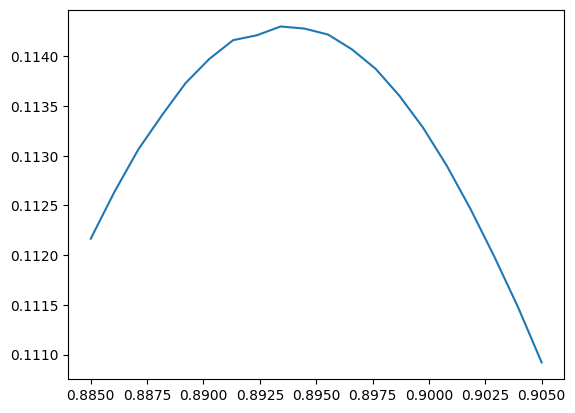

In [175]:
flux_array = [] #transmission flux array

#load the batch results
for task_name, sim_data in grating_batch_results.items():
    pitch_flux = sim_data["flux"].flux
    flux_array.append(pitch_flux)

#find the optimal pitch
optimal_pitch_index = np.argmax(flux_array)
optimal_pitch = pitch_sweep[optimal_pitch_index]
print(optimal_pitch)

#plot flux data array
plt.plot(pitch_sweep, flux_array)

15:50:33 UTC Created task 'grating_coupler_beam' with task_id                   
             'fdve-59598402-8558-4ad0-a9cc-024feba3fed6' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=621939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59598402-8558-4ad0-a9cc-024feba3fed6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=63786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59598402-8558-4ad0-a9cc-024feba3fed6\taskId]8;;\]8;id=621939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59598402-8558-4ad0-a9cc-024feba3fed6\=]8;;\]8;id=930463;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59598402-8558-4ad0-a9cc-024feba3fed6\fdve]8;;\]8;id=621939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59598402-8558-4ad0-a9cc-024feba3fed6\-59598402-855]8;;\
             ]8;id=621939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59598402-8558-4ad0-a9cc-024feba3fed6\8-4ad0-a9cc-024feba3fed6']8;;\.

Output()

             status = success

Output()

15:50:34 UTC loading simulation from data/grating_coupler_verify.hdf5

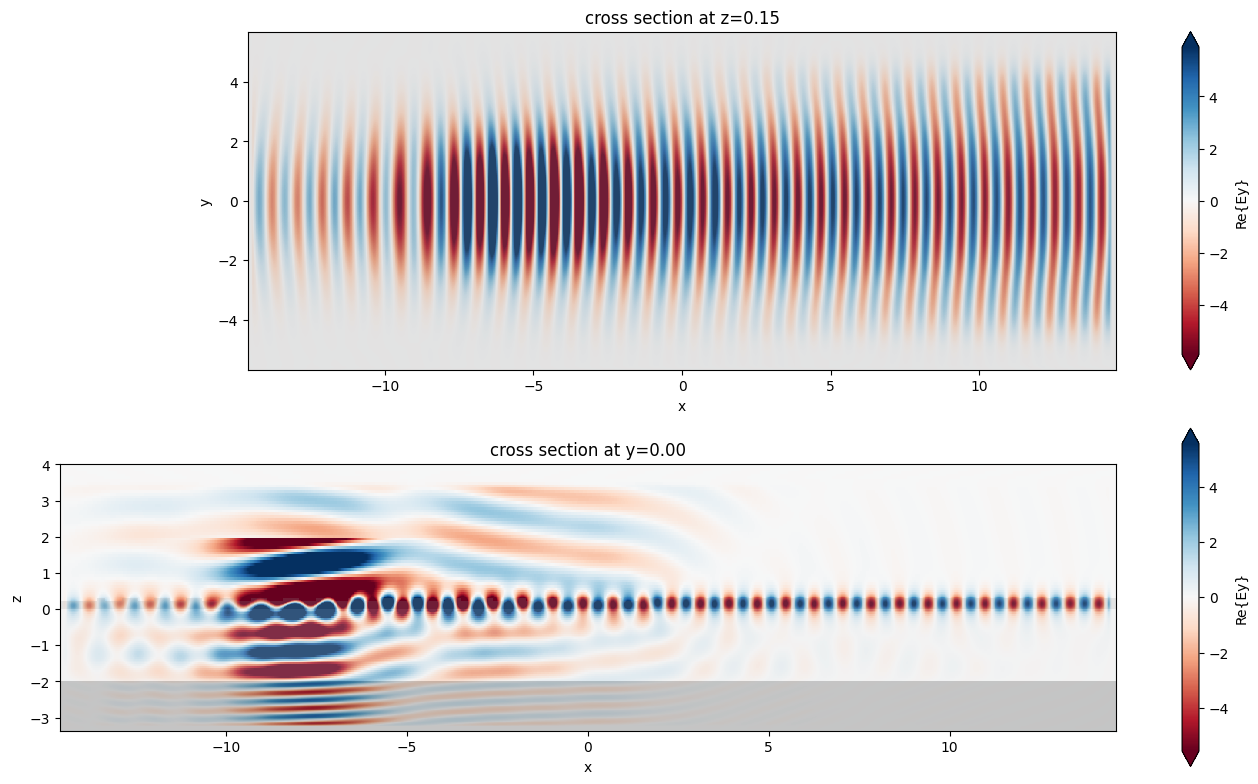

In [176]:
#make the simulation and compute the field
sim_verify = make_pitch_sim(optimal_pitch)
job = web.Job(simulation=sim_verify, task_name="grating_coupler_beam", verbose=True)
sim_data = job.run(path="data/grating_coupler_verify.hdf5")

#plot the field inside the grating coupler 
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)
plt.show()

# Taper Optimization

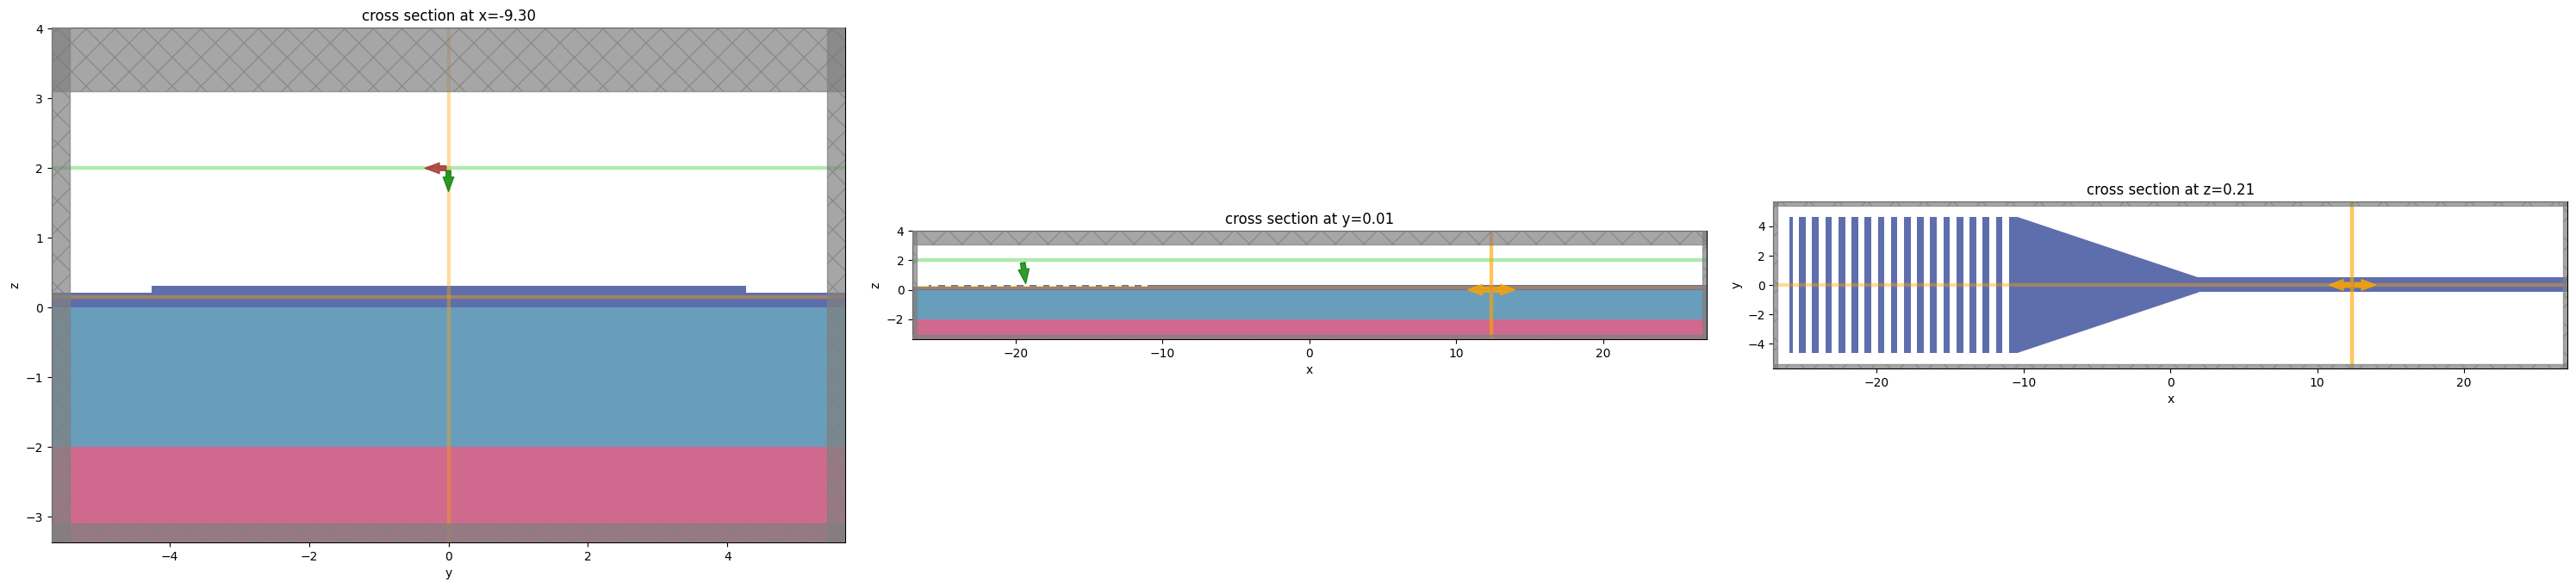

In [255]:
# determine initial pitch guess from diffraction formula 
#pitch_cen = wavelength / (neff - np.sin(abs(design_theta_rad))) #initial pitch guess
taper_cen = 6*wavelength 
taper_shift = wavelength #how far to the left AND right of central pitch to sweep
taper_left = taper_cen - 2*taper_shift
taper_right = taper_cen + 2*taper_shift
num_sweep = 2 # how many steps in the pitch sweep
taper_sweep = np.linspace(taper_left, taper_right, num_sweep)
wg_width = 1.0

def make_taper_sim(taper_length):

    pitch = optimal_pitch
    grating_length = pitch / 2.0 #assumes fill factor of 0.5
    num_gratings = int(cp_length / pitch) 
    
    # sizes
    Lx = buffer + wg_length + 2*taper_length + cp_length+(num_gratings+4)*pitch/2
    Ly = buffer + cp_width + buffer
    Lz = 4 * wavelength
    sim_size = [Lx, Ly, Lz]

    
    sio2_sub = td.Structure(
        geometry=td.Box(
            center=[0, 0, -sio2_height/2],
            size=[td.inf, td.inf, sio2_height],
        ),
        medium=sio2,
        name="sio2 substrate"
    )
    
    si_sub = td.Structure(
        geometry=td.Box(
            center=[0, 0, -sio2_height - si_height/2],
            size=[td.inf, td.inf, si_height],
        ),
        medium=si,
        name="si substrate"
    )
    
    wg_slab = td.Structure(
        geometry=td.Box(
            center=[0, 0, buffer_thickness + slab_thickness/2],
            size=[td.inf, td.inf, slab_thickness],
        ),
        medium=device_mat,
        name="waveguide slab"
    )
    
    wg_buffer = td.Structure(
        geometry=td.Box(
            center=[0, 0, buffer_thickness / 2],
            size=[td.inf, td.inf, buffer_thickness],
        ),
        medium=buffer_mat,
        name="waveguide buffer"
    )
    
    cp = td.Structure(
        geometry=td.Box(
            center=[cp_center_x-taper_length, 0, buffer_thickness + wg_height/2],
            size=[cp_length, cp_width, wg_height],
        ),
        medium=device_mat,
        name="coupler"
    )
    
    #create the gratings
    grating_left_x = cp_center_x - cp_length / 2
    gratings = [
        td.Structure(
            geometry=td.Box(
                center=[
                    grating_left_x + (i + 0.5) * pitch - taper_length,
                    0,
                    wg_height + buffer_thickness,
                ],
                size=[grating_length, cp_width, 2*grating_height],
            ),
            medium=Air,
            name=f"{i}th_grating"
        )
        for i in range(num_gratings)
    ]
    
    tp = td.Structure(
        geometry=td.PolySlab(
            vertices=[
                [cp_center_x + cp_length / 2, +wg_width / 2],
                [cp_center_x + cp_length / 2, -wg_width / 2],
                [cp_center_x + cp_length / 2 - taper_length, -cp_width / 2],
                [cp_center_x + cp_length / 2 - taper_length, +cp_width / 2],
            ],
            slab_bounds=(buffer_thickness, wg_height+buffer_thickness),
            axis=2,
        ),
        medium=device_mat,
        name="taper",
    )

    wg = td.Structure(
    geometry=td.Box(
        center=[wg_center_x+taper_length/2, 0, buffer_thickness + wg_height/2],
        size=[3 * taper_length, wg_width, wg_height],
    ),
    medium=device_mat,
    name="waveguide"
    )

    #gaussian input 
    gaussian_beam = td.GaussianBeam(
        size=(td.inf, td.inf, 0),
        center=[-(num_gratings-1)*pitch/2-taper_length, 0, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        angle_theta= np.abs(design_theta_rad),
        angle_phi=np.pi,
        direction="-",
        waist_radius=2,
        pol_angle=np.pi / 2
    )
    
    plane_monitor = td.FieldMonitor(
    center=[0, 0, wg_height / 2],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="full_domain_fields"
    )

    rad_monitor = td.FieldMonitor(
        center=[0, 0, 0], 
        size=[td.inf, 0, td.inf], freqs=[freq0], 
        name="radiated_fields"
    )
    
    mode_mon = td.ModeMonitor(
        center=(taper_length,0,0),
        size=(0,td.inf,td.inf),
        freqs=[freq0],
        mode_spec = mode_spec,
        name='mode_monitor'
    )

    flux_mon = td.FluxMonitor(
        size=mode_mon.size,
        center=mode_mon.center,
        freqs=[freq0],
        name="flux"
    )

    #create the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[sio2_sub, si_sub, wg_buffer, cp, wg_slab, wg, tp] + gratings,
        sources=[gaussian_beam],
        monitors=[plane_monitor, rad_monitor, mode_mon, flux_mon],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
    )

    return sim

#make a simulation object to test the functions works
taper_sim_test = make_taper_sim(12.4)

#plot the simulation to verify the geometry
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(30, 30))
taper_sim_test.plot(x=-taper_length, ax=ax1)
taper_sim_test.plot(y=0.01, ax=ax2)
taper_sim_test.plot(z=0.21, ax=ax3)
plt.show()

In [250]:
# submit all jobs
# estimate cost first!!
taper_sims = {f"t={t:.3f}": make_taper_sim(t) for t in taper_sweep}
batch_taper = web.Batch(simulations=taper_sims, verbose=True)
#estimate_batch_cost = estimate_cost = web.estimate_cost(batch_taper)
taper_batch_results = batch_taper.run(path_dir="data")

# if needing to disconnect from jupyter server use this code block 
# to save the batch data and load it to process later 
'''
# save batch metadata
taper_batch_results.to_file("data/taper_batch_data.json")

# load batch metadata into a new batch
loaded_taper_batch = web.Batch.from_file("data/taper_batch_data.json")
'''

17:54:12 UTC Created task 't=6.200' with task_id                                
             'fdve-10f8e80a-98fb-457f-8d9c-823ed1153935' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=36002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f8e80a-98fb-457f-8d9c-823ed1153935\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=722954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f8e80a-98fb-457f-8d9c-823ed1153935\taskId]8;;\]8;id=36002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f8e80a-98fb-457f-8d9c-823ed1153935\=]8;;\]8;id=532325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f8e80a-98fb-457f-8d9c-823ed1153935\fdve]8;;\]8;id=36002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f8e80a-98fb-457f-8d9c-823ed1153935\-10f8e80a-98f]8;;\
             ]8;id=36002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f8e80a-98fb-457f-8d9c-823ed1153935\b-457f-8d9c-823ed1153935']8;;\.

Output()

             Created task 't=12.400' with task_id                               
             'fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=470627;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=89925;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e\taskId]8;;\]8;id=470627;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e\=]8;;\]8;id=885775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e\fdve]8;;\]8;id=470627;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e\-b2b6b149-cda]8;;\
             ]8;id=470627;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e\5-4b85-8fb9-c84e427d702e']8;;\.

Output()

17:54:14 UTC Started working on Batch.

             Maximum FlexCredit cost: 19.194 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

17:55:48 UTC Batch complete.

'\n# save batch metadata\ntaper_batch_results.to_file("data/taper_batch_data.json")\n\n# load batch metadata into a new batch\nloaded_taper_batch = web.Batch.from_file("data/taper_batch_data.json")\n'

Output()

17:55:52 UTC loading simulation from                                            
             data/fdve-10f8e80a-98fb-457f-8d9c-823ed1153935.hdf5

Output()

17:55:54 UTC loading simulation from                                            
             data/fdve-b2b6b149-cda5-4b85-8fb9-c84e427d702e.hdf5

6.200000000000001


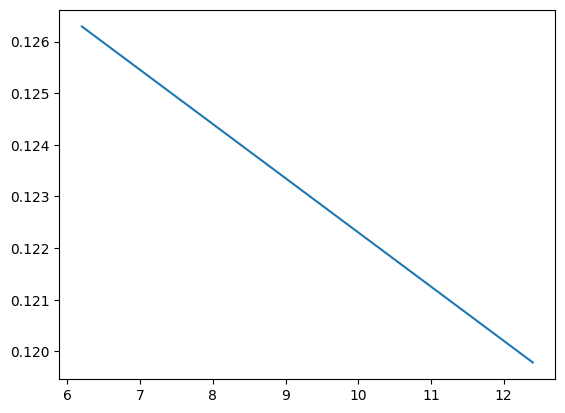

In [251]:
flux_array = [] #transmission flux array

#load the batch results
for task_name, sim_data in taper_batch_results.items():
    taper_flux = sim_data["flux"].flux
    flux_array.append(taper_flux)

#find the optimal pitch
optimal_taper_index = np.argmax(flux_array)
optimal_taper_length = taper_sweep[optimal_taper_index]
print(optimal_taper_length)

#plot flux data array
plt.plot(taper_sweep, flux_array)

21:56:15 UTC Created task 'grating_coupler_beam' with task_id                   
             'fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=392248;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=459689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\taskId]8;;\]8;id=392248;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\=]8;;\]8;id=740504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\fdve]8;;\]8;id=392248;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\-d0bf92ee-fbd]8;;\
             ]8;id=392248;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\5-4cc1-8def-dfadc2c63d62']8;;\.

Output()

21:56:22 UTC status = queued

Output()

21:56:26 UTC status = preprocess

21:56:31 UTC Maximum FlexCredit cost: 8.505. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

21:57:49 UTC early shutoff detected at 16%, exiting.

             status = postprocess

Output()

21:57:56 UTC status = success

21:57:57 UTC View simulation result at                                          
             ]8;id=492500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=161377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\taskId]8;;\]8;id=492500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\=]8;;\]8;id=798265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\fdve]8;;\]8;id=492500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\-d0bf92ee-fbd]8;;\
             ]8;id=492500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0bf92ee-fbd5-4cc1-8def-dfadc2c63d62\5-4cc1-8def-dfadc2c63d62']8;;\.

Output()

             loading simulation from data/grating_coupler_verify.hdf5

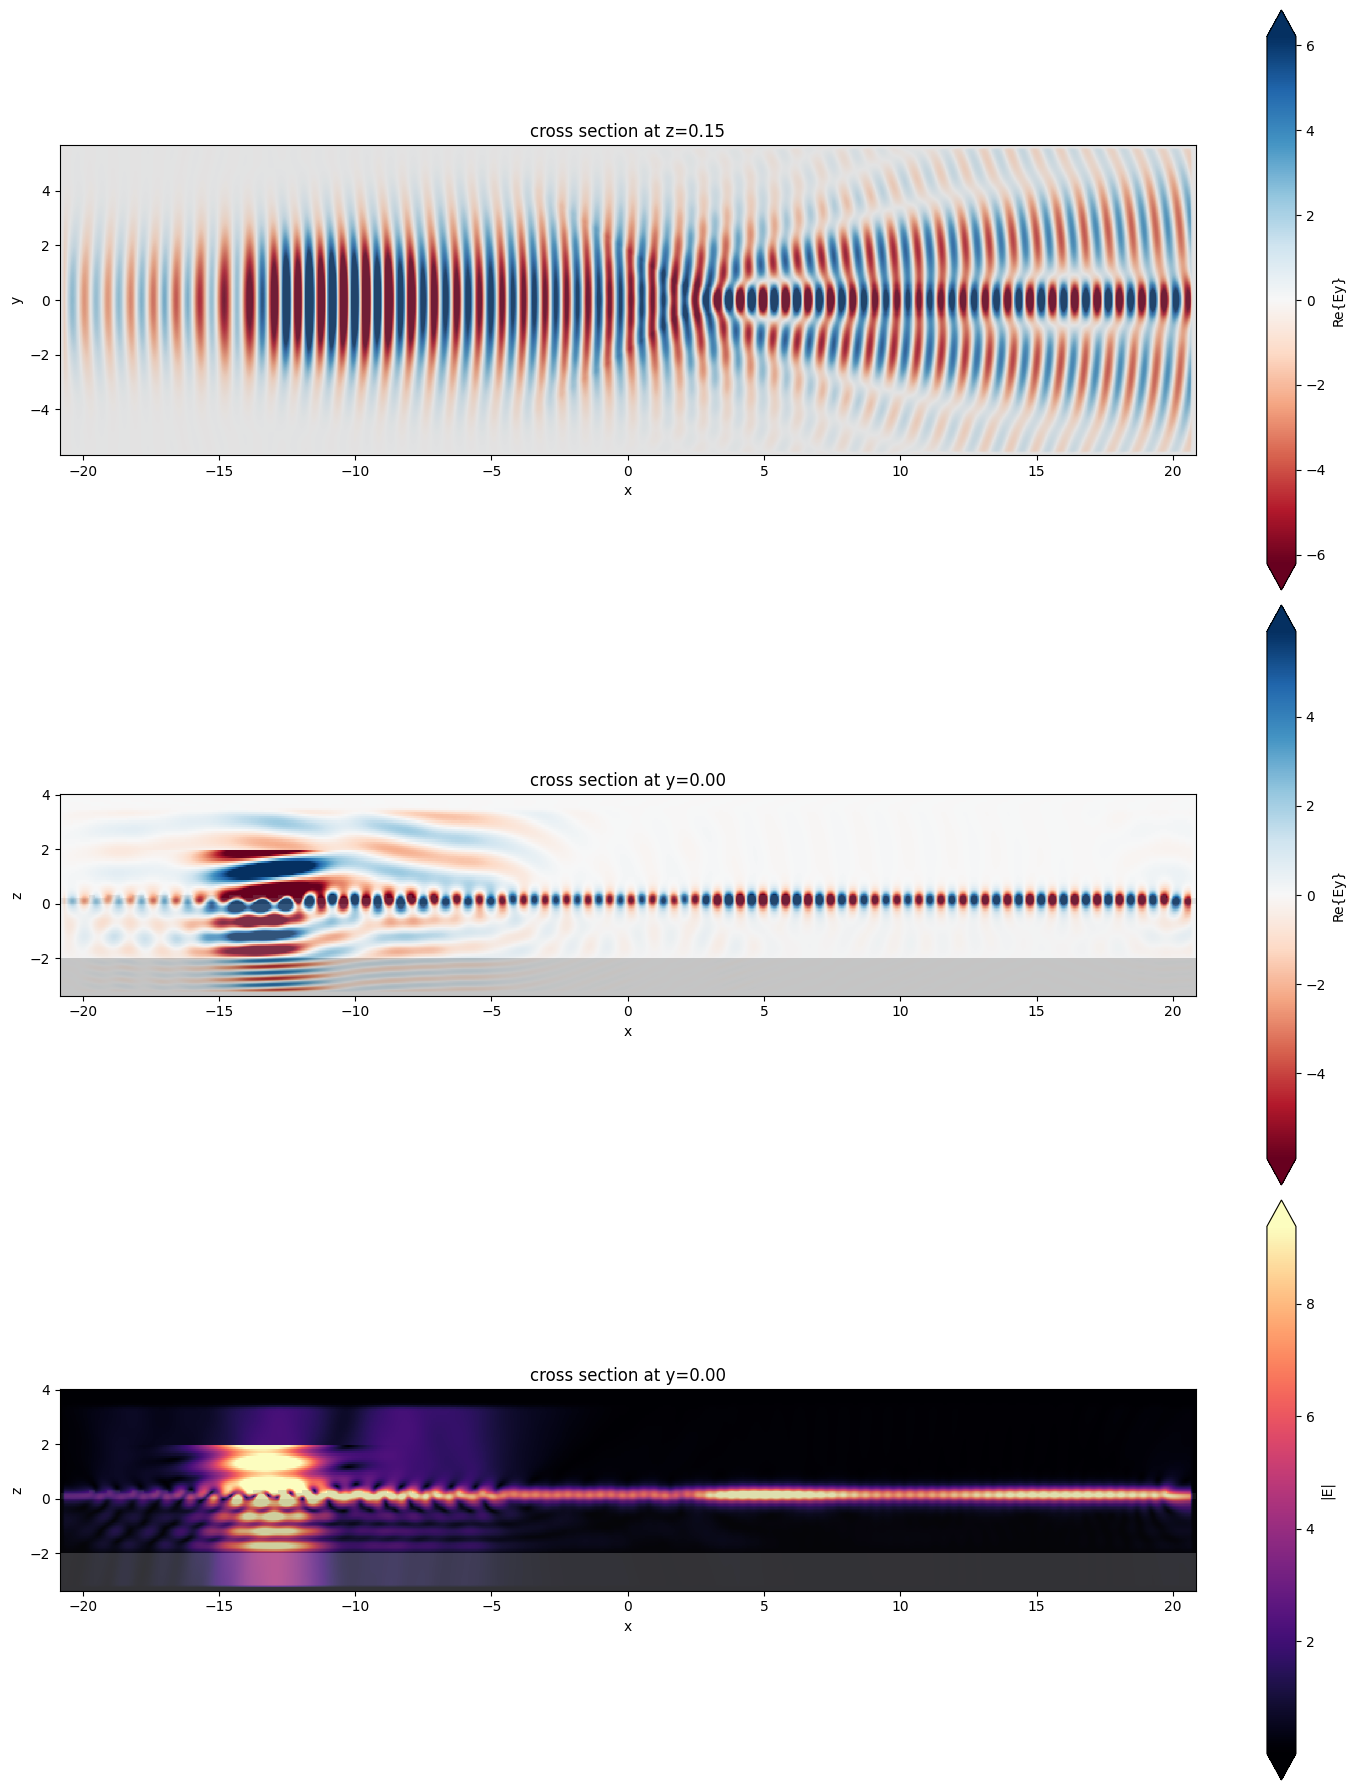

In [256]:
#make the simulation and compute the field
taper_sim_verify = make_taper_sim(optimal_taper_length)
job = web.Job(simulation=taper_sim_verify, task_name="grating_coupler_beam", verbose=True)
taper_sim_data = job.run(path="data/grating_coupler_verify.hdf5")

#plot the field inside the grating coupler 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True, figsize=(15, 6*3))
taper_sim_data.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
taper_sim_data.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)
taper_sim_data.plot_field("radiated_fields", "E", 'abs', f=freq0, ax=ax3)
plt.savefig('coupler_cross_section.png', bbox_inches='tight')
plt.show()

# Bend Optimization

In [38]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 100)  # simulation wavelength range
freqs = td.C_0 / ldas  # simulation wavelength range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

t = mesa_thickness  # thickness of the waveguide
w = mesa_width  # width of the waveguide
inf_eff = 100  # effective infinity of the simulation
buffer = 1  # buffer distance

# the conventional circular bend is simply given by a circle
num_sweep = 30 #number of design parameters to sweep 
bend_start = 30 #start bend radius
bend_end = 60 #end bend radius
r_sweep = np.linspace(bend_start, bend_end, num_sweep)  # bend radius sweep array

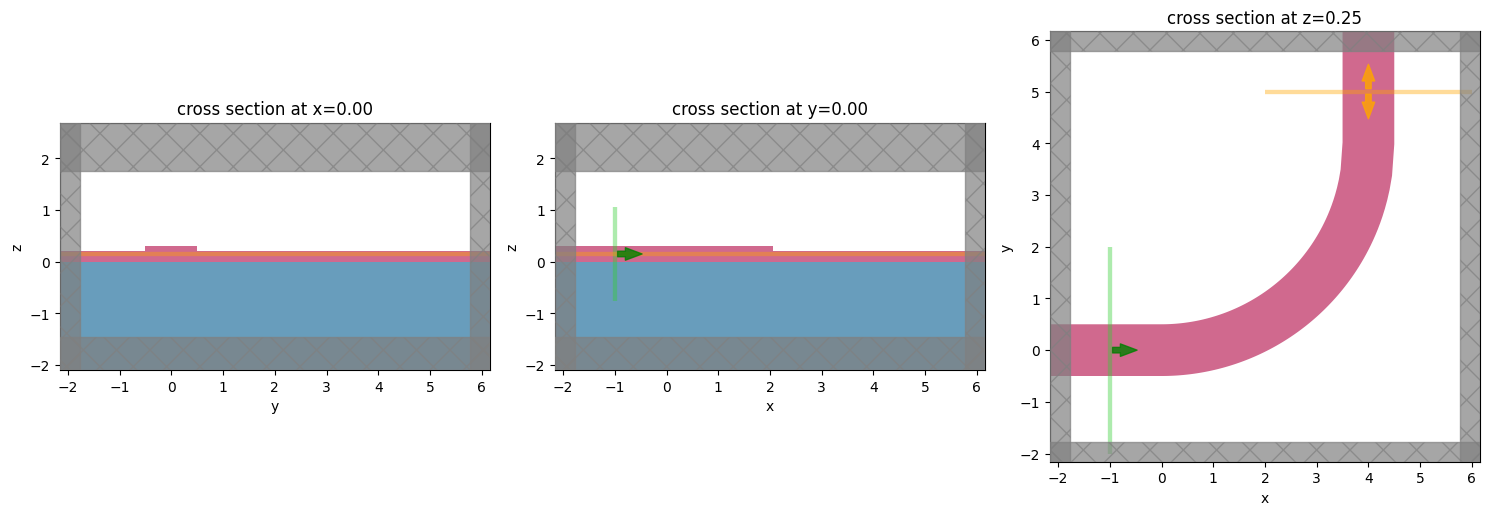

In [39]:
# function that takes the x and y coordinates of a curve and returns a waveguide bend structure with a given width and thickness
def line_to_structure(bend_radius, x, y, w, t):
   
    cell = gdstk.Cell("bend") # define a gds cell
    
    # add points to include the input and output straght waveguides
    x = np.insert(x, 0, -inf_eff)
    x = np.append(x, bend_radius)
    y = np.insert(y,0,0)
    y = np.append(y, inf_eff)

    cell.add(gdstk.FlexPath(x + 1j * y, w, layer=1, datatype=0)) # add path to cell
    
    # define structure from cell
    bend = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0], 
        medium=device_mat
    )


    return bend

#make the substrate, buffer, and BTO slab structures

sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sub_height],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=sub_mat,
    name="substrate",
)

buffer_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, buffer_thickness / 2],
        size=[td.inf, td.inf, buffer_thickness],
    ),
    medium=buffer_mat,
    name="buffer",
)

device_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, slab_thickness/2 + buffer_thickness],
        size=[td.inf, td.inf, slab_thickness],
    ),
    medium=device_mat,
    name="device_slab",
)
    
#helper function that creates the simulation region for a circular radius 
#waveguide width and thickness is determined earlier. those vars are given global scope
def make_bend_sim(bend_radius):
    
    x_circle = np.linspace(0, bend_radius, 100)
    y_circle = -np.sqrt(bend_radius**2 - (x_circle) ** 2) + bend_radius
    circular_bend = line_to_structure(bend_radius, x_circle, y_circle, w, t)

    # add a mode source that launches the fundamental te mode

    mode_source = td.ModeSource(
        center=(-buffer, 0, t / 2),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )
    
    # add a mode monitor to measure transmission
    mode_monitor_ouput = td.ModeMonitor(
        center=(bend_radius, bend_radius + buffer, t / 2),
        size=(4 * w, 0, 6 * t),
        freqs=freq0,
        mode_spec=mode_spec,
        name="mode output",
    )
    
    # add a field monitor to visualize field propagation and leakage in the bend
    field_monitor = td.FieldMonitor(
        center=(bend_radius / 2, bend_radius / 2, t / 2),
        size=(td.inf, td.inf, 0),
        freqs=[freq0],
        colocate=True,
        name="field",
    )
    
    run_time = 5e-12  # simulation run time
    
    # define simulation
    sim = td.Simulation(
        center=(bend_radius / 2, bend_radius / 2, t / 2),
        size=(bend_radius + 2 * w + lda0, bend_radius + 2 * w + lda0, 10 * t + buffer_thickness + slab_thickness),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[sub, buffer_slab, device_slab, circular_bend],
        sources=[mode_source],
        monitors=[mode_monitor_ouput, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),  # pml is applied in all boundaries
    )  

    return sim

#check the bend geometry is drawing correctly 
bend_sim_check = make_bend_sim(4)

# visualize the circular bend structure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 6))
bend_sim_check.plot(x=0, ax=ax1)
bend_sim_check.plot(y=0, ax=ax2)
bend_sim_check.plot(z=0.25, ax=ax3)
plt.show()

In [35]:
# create the batch of simulations
# estimate cost first!!
'''
bend_sims = {f"r={r:.3f}": make_bend_sim(r) for r in r_sweep}
#estimate_bath_cost = estimate_cost = web.estimate_cost(task_id)
batch = web.Batch(simulations=bend_sims, verbose=True)

# submit the batch for calculation
#bend_batch_results = batch.run(path_dir="data")
'''

'''
# save batch metadata
bend_batch_results.to_file("data/bend_batch_data.json")

# load batch metadata into a new batch
loaded_bend_batch = web.Batch.from_file("data/bend_batch_data.json")
'''

18:37:17 UTC loading simulation from                                            
             data/fdve-b3d299d1-b738-4b6b-9891-dd76149d8523.hdf5

18:37:18 UTC loading simulation from                                            
             data/fdve-d7e7b53b-b130-4dd6-a482-80c7762feeab.hdf5

             loading simulation from                                            
             data/fdve-3214a951-8ba8-46a5-94b1-451be83c7c48.hdf5

18:37:19 UTC loading simulation from                                            
             data/fdve-e00e67c9-85a7-44d7-98cb-ab31c9b4bc92.hdf5

18:37:20 UTC loading simulation from                                            
             data/fdve-488df8c1-bdfa-4884-94d3-05eacfadef65.hdf5

             loading simulation from                                            
             data/fdve-dfc784a4-371d-4837-978a-0c5875579132.hdf5

18:37:21 UTC loading simulation from                                            
             data/fdve-bcaa4e47-36e8-4526-842b-9d68fe379275.hdf5

18:37:22 UTC loading simulation from                                            
             data/fdve-60c364d6-2139-4177-82bc-0d657eaac389.hdf5

             loading simulation from                                            
             data/fdve-3a43e3e3-57fa-42af-b101-d92662022716.hdf5

18:37:23 UTC loading simulation from                                            
             data/fdve-5d797726-ca2a-4c48-a3a3-db37b2823772.hdf5

18:37:24 UTC loading simulation from                                            
             data/fdve-37dc1f05-bdbe-4098-bea6-972ba85aadd1.hdf5

18:37:25 UTC loading simulation from                                            
             data/fdve-b37b05ec-4082-4e8c-abc9-054f814eb6af.hdf5

             loading simulation from                                            
             data/fdve-c704c94a-0110-4704-a2bd-825ab2cd4d6d.hdf5

18:37:26 UTC loading simulation from                                            
             data/fdve-3e5a52e3-acce-4c56-b037-de349bd791eb.hdf5

18:37:27 UTC loading simulation from                                            
             data/fdve-c83a8271-2715-42c5-85e9-7ece5ce3690a.hdf5

18:37:28 UTC loading simulation from                                            
             data/fdve-d02b0db1-726e-4b13-8fcd-6c459b475f92.hdf5

             loading simulation from                                            
             data/fdve-14ffe09f-8a89-4389-8b75-563f8a2727e0.hdf5

18:37:29 UTC loading simulation from                                            
             data/fdve-082c804d-8b14-442b-b423-473fe9515812.hdf5

18:37:30 UTC loading simulation from                                            
             data/fdve-2fb5265c-8733-44f5-b5ad-1539717956d8.hdf5

18:37:31 UTC loading simulation from                                            
             data/fdve-4f1a160a-7e98-401f-8095-b922ae2071e9.hdf5

18:37:32 UTC loading simulation from                                            
             data/fdve-b2fa44bd-1ae6-41cf-8745-17b4b56daec8.hdf5

18:37:34 UTC loading simulation from                                            
             data/fdve-68c69a04-4647-4b8b-a883-7facad7987c3.hdf5

18:37:35 UTC loading simulation from                                            
             data/fdve-699cc45c-dbf4-4ef8-a7ea-9a167bdd36d9.hdf5

18:37:36 UTC loading simulation from                                            
             data/fdve-e1178712-9930-4720-b48b-0438693ef9f9.hdf5

18:37:37 UTC loading simulation from                                            
             data/fdve-381d46c3-8735-4b64-88b2-c014e1a06327.hdf5

18:37:38 UTC loading simulation from                                            
             data/fdve-d3070447-f183-46b0-b866-9f708a328e8d.hdf5

18:37:39 UTC loading simulation from                                            
             data/fdve-3183b576-28da-4466-b23a-42ae44603ca4.hdf5

18:37:40 UTC loading simulation from                                            
             data/fdve-758bdd41-2347-4a51-8a07-33cc8e71f00b.hdf5

18:37:42 UTC loading simulation from                                            
             data/fdve-635dd7f0-67d0-4712-b827-592a13ace74a.hdf5

18:37:43 UTC loading simulation from                                            
             data/fdve-406ab50d-035b-4ee8-8fde-c4af650afc11.hdf5

0.24409165721936238
50.3448275862069


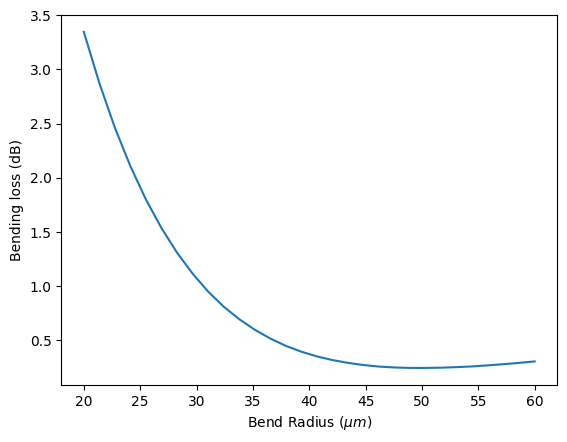

In [43]:
T_array_cicular = [] #transmission flux array

#load the batch results
for task_name, sim_data in bend_batch_results.items():
    amp = sim_data["mode ouput"].amps.sel(mode_index=0, direction="+")
    T_circular = np.abs(amp)**2 
    T_array_circular.append(T_circular)

#find the optimal bend radius
optimal_bend_index = np.argmin(-10 * np.log10(T_array_circular))
print(np.min(-10 * np.log10(T_array_circular)))
optimal_bend = r_sweep[optimal_bend_index]
print(optimal_bend)

# plot the bending loss as a function of wavelength
plt.plot(r_sweep, -10 * np.log10(T_array_circular))
plt.xlabel("Bend Radius ($\mu m$)")
plt.ylabel("Bending loss (dB)")
plt.show()

18:33:21 UTC Created task 'circular_bend' with task_id                          
             'fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=313375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=767701;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9\taskId]8;;\]8;id=313375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9\=]8;;\]8;id=775562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9\fdve]8;;\]8;id=313375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9\-67cb17e4-01b]8;;\
             ]8;id=313375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67cb17e4-01ba-41da-9660-0b2f208f46b9\a-41da-9660-0b2f208f46b9']8;;\.

Output()

18:33:22 UTC status = success

Output()

18:33:23 UTC loading simulation from data/simulation_data_circular.hdf5

/opt/conda/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


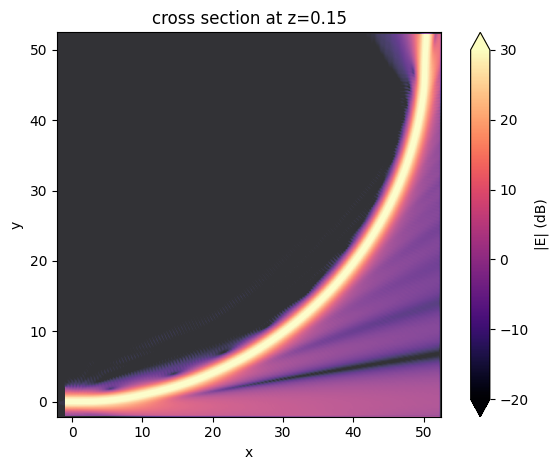

In [37]:
#verify the bend result by viewing the field 
bend_sim_verify = make_bend_sim(optimal_bend)

job = web.Job(simulation=bend_sim_verify, task_name="circular_bend")
sim_data_circular = job.run(path="data/simulation_data_circular.hdf5")

#show the field inside the optimal bend radius
sim_data_circular.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()

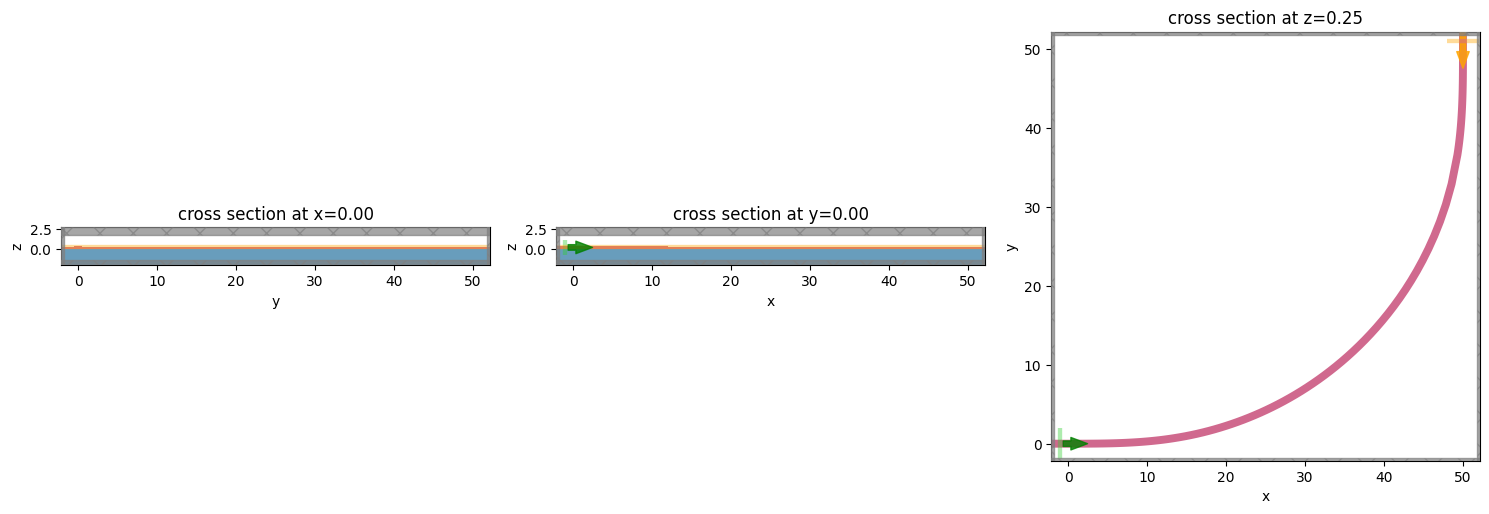

In [40]:
# create the euler waveguide bend structure
def make_euler_bend_sim(bend_radius, clothoid_parameter):

    #make the euler coordinates
    R_eff = bend_radius  # effective radius of the bend
    A = clothoid_parameter  # clothoid parameter
    
    L_max = 0  # starting point of L_max
    precision = 0.001  # increasement of L_max at each iteration
    tolerance = 0.005  # difference tolerance of the derivatives
    
    # determine L_max
    while True:
        L_max = L_max + precision  # update L_max
        Ls = np.linspace(0, L_max, 50)  # L at (x1,y1)
        x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
        y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve
    
        # compute x1 and y1 using the above integral equations
        for i, L in enumerate(Ls):
            y1[i], err = integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)
            x1[i], err = integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)
    
        # compute the derivative at L_max
        k = -(x1[-1] - x1[-2]) / (y1[-1] - y1[-2])
        xp = x1[-1]
        yp = y1[-1]
        # check if the derivative is continuous at L_max
        R = np.sqrt(
            ((R_eff + k * xp - yp) / (k + 1) - xp) ** 2
            + (-(R_eff + k * xp - yp) / (k + 1) + R_eff - yp) ** 2
        )
        if np.abs(R - A**2 / L_max) < tolerance:
            break
    
    # after L_max is determined, R_min is also determined
    R_min = A**2 / L_max
    
    # getting the coordinates of the second clothoid curve by mirroring the first curve with respect to y=-x+R_eff
    x3 = np.flipud(R_eff - y1)
    y3 = np.flipud(R_eff - x1)
    
    # solve for the parameters of the circular curve
    def circle(var):
        a = var[0]
        b = var[1]
        Func = np.empty((2))
        Func[0] = (xp - a) ** 2 + (yp - b) ** 2 - R_min**2
        Func[1] = (R_eff - yp - a) ** 2 + (R_eff - xp - b) ** 2 - R_min**2
        return Func
    
    
    a, b = fsolve(circle, (0, R_eff))
    
    # calculate the coordinates of the circular curve
    x2 = np.linspace(xp + 0.01, R_eff - yp - 0.01, 50)
    y2 = -np.sqrt(R_min**2 - (x2 - a) ** 2) + b
    
    # the conventional circular bend is simply given by a circle
    x_circle = np.linspace(0, R_eff, 100)
    y_circle = -np.sqrt(R_eff**2 - (x_circle) ** 2) + R_eff
    
    # obtain the coordinates of the whole Euler bend by concatenating three pieces together
    x_euler = np.concatenate((x1, x2, x3))
    y_euler = np.concatenate((y1, y2, y3))
    
    #make the line struture we will do a sweep extrusion along to make waveguide
    euler_bend = line_to_structure(bend_radius, x_euler, y_euler, w, t)
    
    # add a mode source that launches the fundamental te mode
    mode_source = td.ModeSource(
        center=(-buffer, 0, t / 2),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )
    
    # add a mode monitor to measure transmission
    mode_monitor = td.ModeMonitor(
        center=(bend_radius, bend_radius + buffer, t / 2),
        size=(4 * w, 0, 6 * t),
        freqs=freq0,
        mode_spec=mode_spec,
        name="mode",
    )
    
    # add a field monitor to visualize field propagation and leakage in the bend
    field_monitor = td.FieldMonitor(
        center=(bend_radius / 2, bend_radius / 2, t / 2),
        size=(td.inf, td.inf, 0),
        freqs=[freq0],
        colocate=True,
        name="field",
    )
    
    run_time = 5e-12  # simulation run time
    
    # define simulation
    sim = td.Simulation(
        center=(bend_radius / 2, bend_radius / 2, t / 2),
        size=(bend_radius + 2 * w + lda0, bend_radius + 2 * w + lda0, 10 * t + buffer_thickness + slab_thickness),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[sub, buffer_slab, device_slab, euler_bend],
        sources=[mode_source],
        monitors=[mode_monitor, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),  # pml is applied in all boundaries
    )  
    return sim

#check the euler bend geometry is drawing correctly 
#euler_bend_sim_check = make_euler_bend_sim(optimal_bend, 24)
euler_bend_sim_check = make_euler_bend_sim(50, 24.6)

# visualize the euler bend structure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 6))
euler_bend_sim_check.plot(x=0, ax=ax1)
euler_bend_sim_check.plot(y=0, ax=ax2)
euler_bend_sim_check.plot(z=0.25, ax=ax3)
plt.show()

In [131]:
#clothoid sweep array. playing around with the parameter shows 
#between 25 and 33 are good values for a coarse sweep 
clothoid_start = 24
clothoid_end = 26
clothoid_num_points = 10
clothoid_sweep = np.linspace(clothoid_start, clothoid_end, clothoid_num_points)

# create the batch of simulations
# estimate cost first!!
'''
# create the batch of simulations
euler_bend_sims = {f"a={a:.3f}": make_euler_bend_sim(optimal_bend, a) for a in clothoid_sweep}
batch = web.Batch(simulations=euler_bend_sims, verbose=True)
#estimate_cost = web.estimate_cost(task_id)

# submit the batch for calculation
#euler_bend_batch_results = batch.run(path_dir="data")
'''
'''
# save batch metadata
euler_bend_batch_results.to_file("data/euler_bend_batch_data.json")

# load batch metadata into a new batch
loaded_euler_bend_batch = web.Batch.from_file("data/euler_bend_batch_data.json")
'''

Output()

21:14:49 UTC loading simulation from                                            
             data/fdve-0167b7f3-29b2-43cd-b15d-797d55a98526.hdf5

Output()

21:14:52 UTC loading simulation from                                            
             data/fdve-9e8b3b7a-197d-4444-8941-8b56e2e4846c.hdf5

Output()

21:14:55 UTC loading simulation from                                            
             data/fdve-6f44fc59-8a75-4b73-b9b6-3aad26a88d94.hdf5

Output()

21:14:58 UTC loading simulation from                                            
             data/fdve-66fa53e6-8274-471a-946d-febfd93b5cab.hdf5

Output()

21:15:00 UTC loading simulation from                                            
             data/fdve-06243a36-1b34-40c3-ab95-fdb9763d6809.hdf5

Output()

21:15:03 UTC loading simulation from                                            
             data/fdve-0cad50a4-18b3-41a9-8a70-209c7ab41cad.hdf5

Output()

21:15:06 UTC loading simulation from                                            
             data/fdve-26936366-0ab4-48ec-a5c1-321a51fa5641.hdf5

Output()

21:15:09 UTC loading simulation from                                            
             data/fdve-579b458d-c729-4232-a24a-7860d614d845.hdf5

Output()

21:15:11 UTC loading simulation from                                            
             data/fdve-26cee897-342e-4a5c-9033-927fd4d76187.hdf5

Output()

21:15:14 UTC loading simulation from                                            
             data/fdve-c9f3e1b7-cccd-4af9-81bd-4c4bb713bd83.hdf5

0.12790005922504424
24.666666666666668


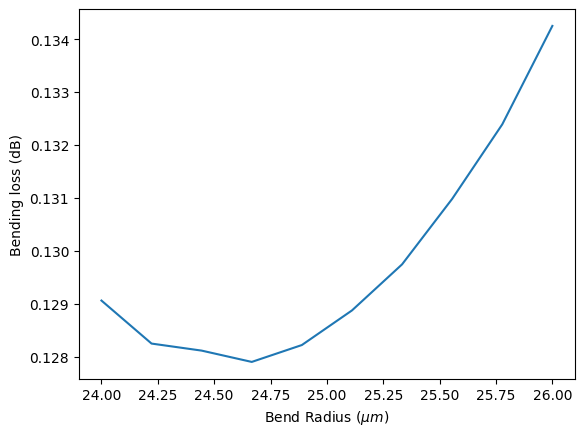

In [128]:
T_array_euler = [] #transmission flux array

#load the batch results
for task_name, sim_data in euler_bend_batch_results.items():
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+")
    T_euler = np.abs(amp)**2 
    T_array_euler.append(T_euler)

#find the optimal bend radius
optimal_clothoid_index = np.argmin(-10 * np.log10(T_array_euler))
print(np.min(-10 * np.log10(T_array_euler)))
optimal_clothoid_param = clothoid_sweep[optimal_clothoid_index]
print(optimal_clothoid_param)

# plot the bending loss as a function of wavelength
plt.plot(clothoid_sweep, -10 * np.log10(T_array_euler))
plt.xlabel("Clothoid Parameter ($no units$)")
plt.ylabel("Bending loss (dB)")
plt.show()

sim constructed successfully


21:19:32 UTC Created task 'euler_bend' with task_id                             
             'fdve-8a180afd-4a0b-4232-adf1-c08e19298059' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=546029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a180afd-4a0b-4232-adf1-c08e19298059\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=562145;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a180afd-4a0b-4232-adf1-c08e19298059\taskId]8;;\]8;id=546029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a180afd-4a0b-4232-adf1-c08e19298059\=]8;;\]8;id=492427;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a180afd-4a0b-4232-adf1-c08e19298059\fdve]8;;\]8;id=546029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a180afd-4a0b-4232-adf1-c08e19298059\-8a180afd-4a0]8;;\
             ]8;id=546029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a180afd-4a0b-4232-adf1-c08e19298059\b-4232-adf1-c08e19298059']8;;\.

Output()

             status = success

Output()

21:19:33 UTC loading simulation from data/simulation_data_euler.hdf5

/opt/conda/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


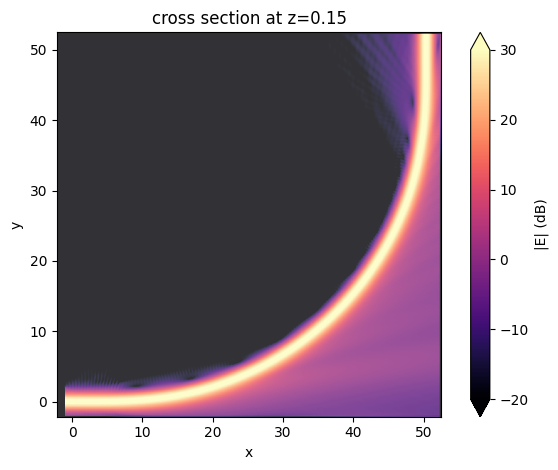

In [129]:
#verify the bend result by viewing the field 
euler_bend_sim_verify = make_euler_bend_sim(optimal_bend, optimal_clothoid_param)

job = web.Job(simulation=euler_bend_sim_verify, task_name="euler_bend")
sim_data_euler = job.run(path="data/simulation_data_euler.hdf5")

#show the field inside the optimal bend radius
sim_data_euler.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)

plt.show()

# Check Mode Leakage in Bend Radius

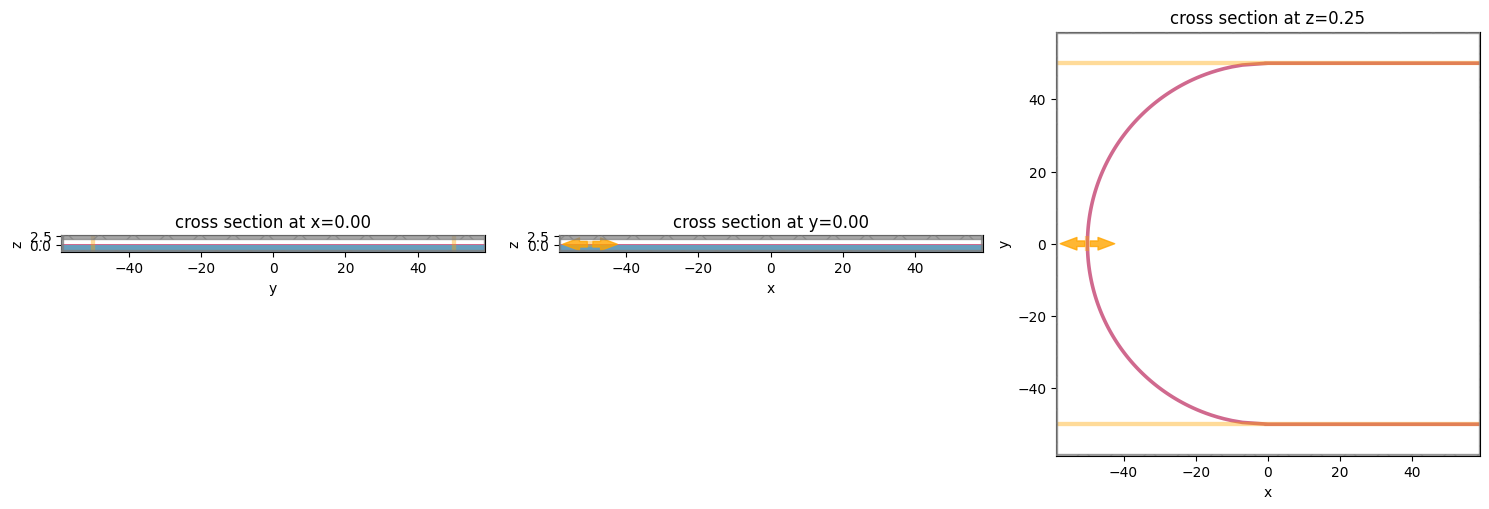

In [45]:
sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sub_height],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=sub_mat,
    name="substrate",
)

buffer_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, buffer_thickness / 2],
        size=[td.inf, td.inf, buffer_thickness],
    ),
    medium=buffer_mat,
    name="buffer",
)

device_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, slab_thickness/2 + buffer_thickness],
        size=[td.inf, td.inf, slab_thickness],
    ),
    medium=device_mat,
    name="device_slab",
)

#make a helper function to generate the euler curve & circle curve
def make_sweep_curve(bend_radius, clothoid_parameter, euler_bend_boolean):
    #make the euler coordinates
    R_eff = bend_radius  # effective radius of the bend
    A = clothoid_parameter  # clothoid parameter
    
    L_max = 0  # starting point of L_max
    precision = 0.001  # increasement of L_max at each iteration
    tolerance = 0.005  # difference tolerance of the derivatives
    if euler_bend_boolean: 
        # determine L_max
        while True:
            L_max = L_max + precision  # update L_max
            Ls = np.linspace(0, L_max, 50)  # L at (x1,y1)
            x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
            y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve
        
            # compute x1 and y1 using the above integral equations
            for i, L in enumerate(Ls):
                y1[i], err = integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)
                x1[i], err = integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)
        
            # compute the derivative at L_max
            k = -(x1[-1] - x1[-2]) / (y1[-1] - y1[-2])
            xp = x1[-1]
            yp = y1[-1]
            # check if the derivative is continuous at L_max
            R = np.sqrt(
                ((R_eff + k * xp - yp) / (k + 1) - xp) ** 2
                + (-(R_eff + k * xp - yp) / (k + 1) + R_eff - yp) ** 2
            )
            if np.abs(R - A**2 / L_max) < tolerance:
                break
        
        # after L_max is determined, R_min is also determined
        R_min = A**2 / L_max
        
        # getting the coordinates of the second clothoid curve by mirroring the first curve with respect to y=-x+R_eff
        x3 = np.flipud(R_eff - y1)
        y3 = np.flipud(R_eff - x1)
        
        # solve for the parameters of the circular curve
        def circle(var):
            a = var[0]
            b = var[1]
            Func = np.empty((2))
            Func[0] = (xp - a) ** 2 + (yp - b) ** 2 - R_min**2
            Func[1] = (R_eff - yp - a) ** 2 + (R_eff - xp - b) ** 2 - R_min**2
            return Func
        
        a, b = fsolve(circle, (0, R_eff))
        
        # calculate the coordinates of the circular curve
        x2 = np.linspace(xp + 0.01, R_eff - yp - 0.01, 50)
        y2 = -np.sqrt(R_min**2 - (x2 - a) ** 2) + b

        # obtain the coordinates of the whole Euler bend by concatenating three pieces together
        # should make a full 180 degree euler bend
        x = np.concatenate((-np.flip(x3), -np.flip(x2), -np.flip(x1), x1, x2, x3))
        y = np.concatenate((np.flip(y3), np.flip(y2), np.flip(y1), y1, y2, y3))

    else:
        # the conventional circular bend is simply given by a circle
        # should make a full 180 degree circular bend
        x = np.linspace(-R_eff, R_eff, 200)
        y = -np.sqrt(R_eff**2 - x ** 2) + R_eff

    #returns a tuple of the euler curve and corresponding conventional circular curve
    return (x, y)

# function that takes the x and y coordinates of a curve and returns a waveguide bend structure with a given width and thickness
def line_to_wg_struct_leakage(bend_radius, x, y, w, t, arm_length):
   
    cell = gdstk.Cell("wg_structure") # define a gds cell
    bend = gdstk.FlexPath((x - bend_radius) + 1j * y, w, layer=1, datatype=0) #define first bend
    arm_length_array = np.linspace(-arm_length/2 - arm_length/100, arm_length/2 + arm_length/100, 100)
    arm_top = gdstk.FlexPath((arm_length_array + bend_radius) + 1j * bend_radius, w, layer=1, datatype=0) #define arm 1
    arm_bottom = gdstk.FlexPath((arm_length_array + bend_radius) - 1j * bend_radius, w, layer=1, datatype=0) #define arm 2
                           
    cell.add(bend, arm_top, arm_bottom) # add path to cell
    
    wg_structure = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0], 
        medium=device_mat
    )

    return wg_structure

def make_ridge_waveguide_leakage(bend_radius, arm_length, clothoid_param, euler_bend_boolean):
    
    curve_sweep = make_sweep_curve(bend_radius, clothoid_param, euler_bend_boolean)
    
    bend_structure = line_to_wg_struct_leakage(bend_radius, curve_sweep[1], curve_sweep[0], w, t, arm_length)
    
    # add a mode source that launches the fundamental te mode
    mode_source = td.ModeSource(
        center=(buffer, -bend_radius, t / 2),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="-",
        mode_spec=mode_spec,
        mode_index=0,
    )
    
    # add a mode monitor to measure transmission
    mode_monitor = td.ModeMonitor(
        center=(-bend_radius, 0, t / 2),
        size=(0, 4 * w, 6 * t),
        freqs=freq0,
        mode_spec=mode_spec,
        name="mode",
    )

    # add a field monitor to visualize field propagation and leakage in the bend
    field_monitor_input_arm = td.FieldMonitor(
        center=(bend_radius / 2, -bend_radius, t / 2),
        size=(td.inf, 0, td.inf),
        freqs=[freq0],
        colocate=True,
        name="field input cross section",
    )

    # add a field monitor to visualize field propagation and leakage in the bend
    field_monitor_output_arm = td.FieldMonitor(
        center=(bend_radius / 2, bend_radius, t / 2),
        size=(td.inf, 0, td.inf),
        freqs=[freq0],
        colocate=True,
        name="field output cross section",
    )
    
    run_time = 5e-12  # simulation run time
    
    # define simulation
    sim = td.Simulation(
        center=(0, 0, t / 2),
        size=(bend_radius + (arm_length / 1.5), 
              bend_radius + (arm_length / 1.5), 
              10 * t + buffer_thickness
             ),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[sub, buffer_slab, device_slab, bend_structure],
        sources=[],
        monitors=[mode_monitor, field_monitor_input_arm, field_monitor_output_arm],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),  # pml is applied in all boundaries
    )

    return sim

#check the bend geometry is drawing correctly 
waveguide_sim_check_leakage_check = make_ridge_waveguide_leakage(50, 100, 24.6, False)

# visualize the circular bend structure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 6))
waveguide_sim_check_leakage_check.plot(x=0, ax=ax1)
waveguide_sim_check_leakage_check.plot(y=0, ax=ax2)
waveguide_sim_check_leakage_check.plot(z=0.25, ax=ax3)
plt.show()

15:53:40 UTC WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 2 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 3 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 4 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 5 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 6 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 8 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 10 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 11 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 13 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 14 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 15 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 17 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 18 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 19 does not   
             decay at the plane boundaries.                                     

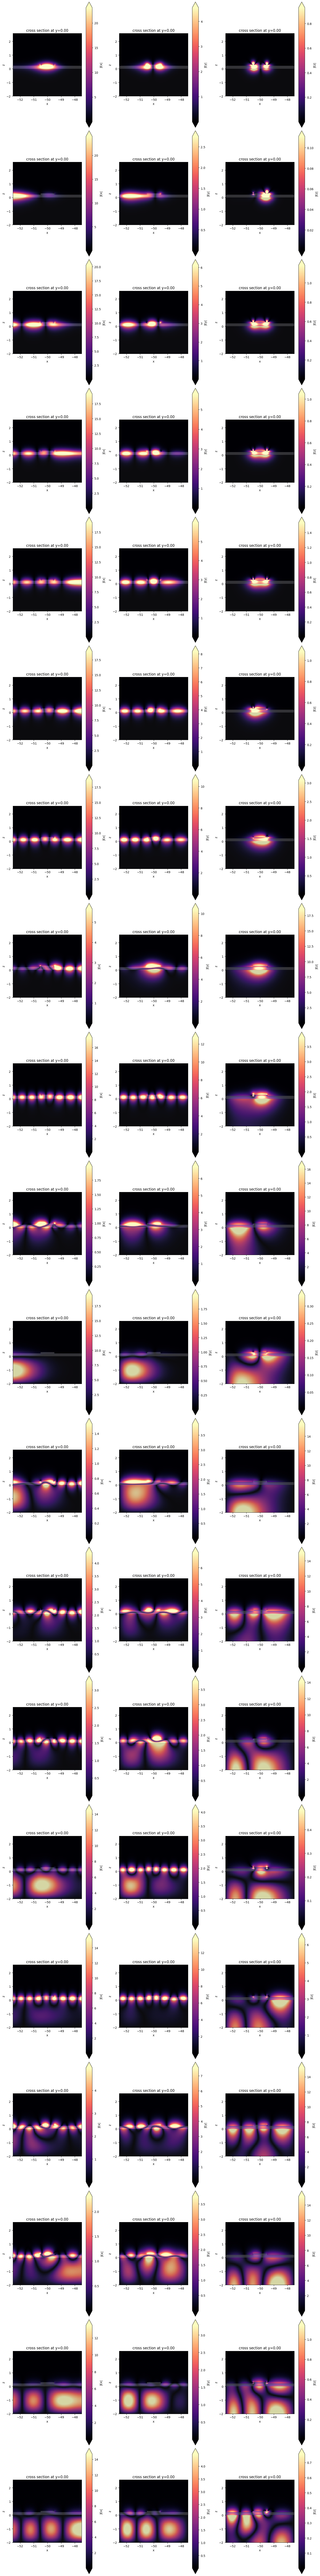

In [32]:
# Modal source plane
bend_radius = 50
source_plane = td.Box(center=[-bend_radius, 0, t / 2], size=[5, 0, 5])

waveguide_sim_check_leakage_circ = make_ridge_waveguide_leakage(bend_radius, 100, 24.6, False)

num_modes = 20
# NB: negative radius since the plane position is at y=-radius
mode_spec = td.ModeSpec(num_modes=num_modes, 
                        bend_radius = -bend_radius, 
                        bend_axis = 1,
                        target_neff = device_no,
                       )

modes_circ_bend = ModeSolver(simulation=waveguide_sim_check_leakage_circ, 
                             plane=source_plane, 
                             freqs=[freq0], 
                             mode_spec=mode_spec,
                            )

modes_circ_bend_data = modes_circ_bend.solve()

n_complex_bend = modes_circ_bend_data.n_complex  # complex effective index as a DataArray
n_eff_bend = modes_circ_bend_data.n_eff.values  # real part of the effective index as numpy array
k_eff_bend = modes_circ_bend_data.k_eff.values  # imag part of the effective index as numpy array

# print mode data
modes_circ_bend_data.to_dataframe()

f, axes = plt.subplots(num_modes, 3, tight_layout=True, figsize=(15, 6*num_modes))
for axe, mode_index in zip(axes, range(num_modes)):
    for ax, field_name in zip(axe, ("Ex", "Ey", "Ez")):
        modes_circ_bend.plot_field(field_name, "abs", f=freq0, mode_index=mode_index, ax=ax)
        
plt.savefig('mode_circ_bend_plots.png', bbox_inches='tight')
plt.show()

15:55:43 UTC WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 2 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 3 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 4 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 5 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 6 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 8 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 10 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 11 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 13 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 14 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 15 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 17 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 18 does not   
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 19 does not   
             decay at the plane boundaries.                                     

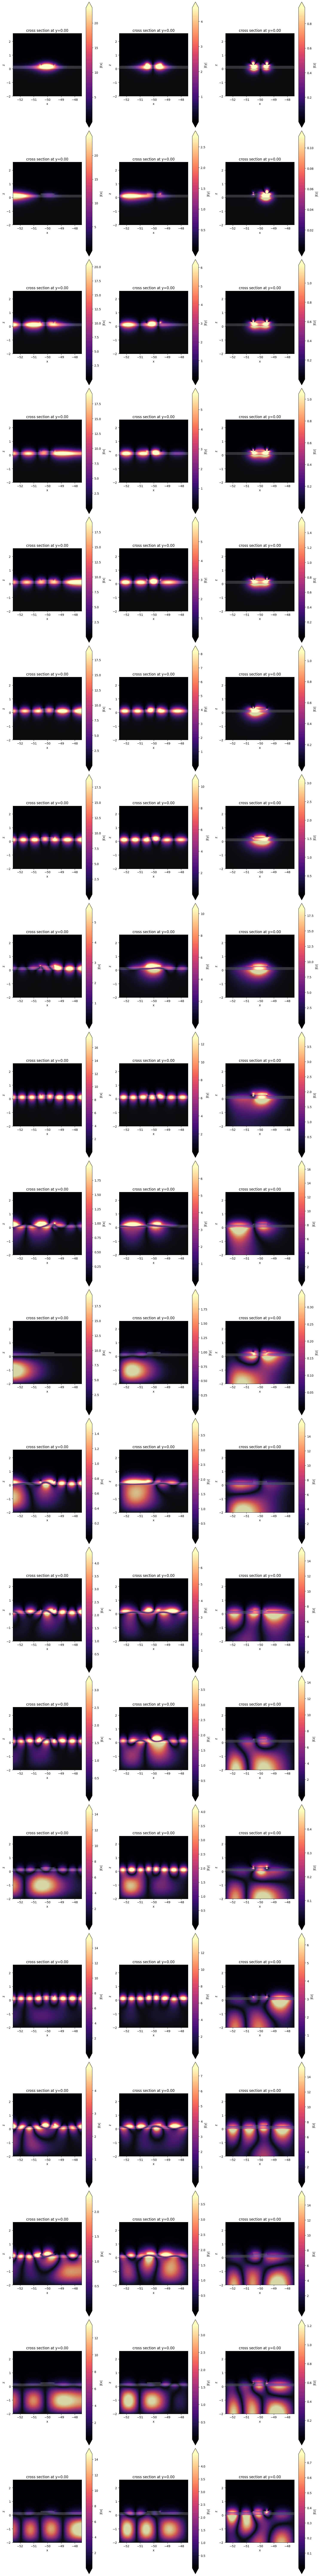

In [34]:
# do the same thing but for the clothoid bend

# Modal source plane
bend_radius = 50
waveguide_sim_leakage_euler = make_ridge_waveguide_leakage(bend_radius, 100, 24.6, True)
source_plane = td.Box(center=[-bend_radius, 0, t / 2], size=[5, 0, 5])

modes_euler_bend = ModeSolver(simulation=waveguide_sim_leakage_euler, 
                             plane=source_plane, 
                             freqs=[freq0], 
                             mode_spec=mode_spec,
                            )

modes_euler_bend_data = modes_euler_bend.solve()

n_complex_bend_euler = modes_euler_bend_data.n_complex  # complex effective index as a DataArray
n_eff_bend_euler = modes_euler_bend_data.n_eff.values  # real part of the effective index as numpy array
k_eff_bend_euler = modes_euler_bend_data.k_eff.values  # imag part of the effective index as numpy array

# print mode data
modes_euler_bend_data.to_dataframe()


f, axes = plt.subplots(num_modes, 3, tight_layout=True, figsize=(15, 6*num_modes))
for axe, mode_index in zip(axes, range(num_modes)):
    for ax, field_name in zip(axe, ("Ex", "Ey", "Ez")):
        modes_euler_bend.plot_field(field_name, "abs", f=freq0, mode_index=mode_index, ax=ax)
        
plt.savefig('mode_euler_bend_plots.png', bbox_inches='tight')
plt.show()

# Projected Losses in Waveguide

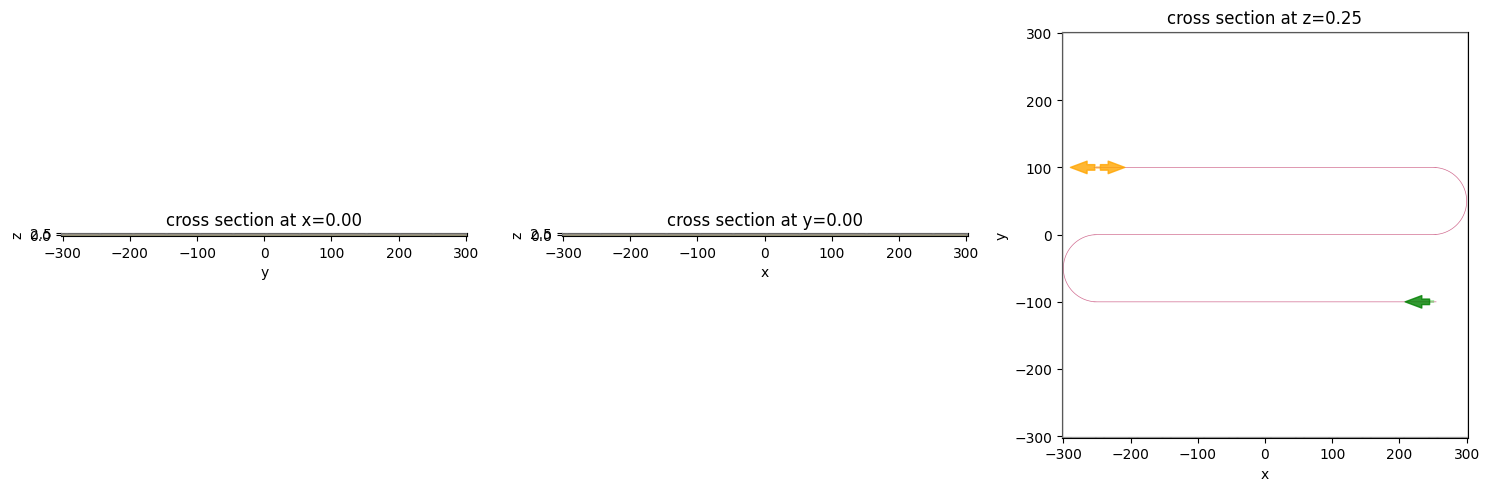

In [37]:
sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sub_height],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=sub_mat,
    name="substrate",
)

buffer_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, buffer_thickness / 2],
        size=[td.inf, td.inf, buffer_thickness],
    ),
    medium=buffer_mat,
    name="buffer",
)

device_slab = td.Structure(
    geometry=td.Box(
        center=[0, 0, slab_thickness/2 + buffer_thickness],
        size=[td.inf, td.inf, slab_thickness],
    ),
    medium=device_mat,
    name="device_slab",
)

#make a helper function to generate the euler curve & circle curve
def make_sweep_curve(bend_radius, clothoid_parameter, euler_bend_boolean):
    #make the euler coordinates
    R_eff = bend_radius  # effective radius of the bend
    A = clothoid_parameter  # clothoid parameter
    
    L_max = 0  # starting point of L_max
    precision = 0.001  # increasement of L_max at each iteration
    tolerance = 0.005  # difference tolerance of the derivatives
    if euler_bend_boolean: 
        # determine L_max
        while True:
            L_max = L_max + precision  # update L_max
            Ls = np.linspace(0, L_max, 50)  # L at (x1,y1)
            x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
            y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve
        
            # compute x1 and y1 using the above integral equations
            for i, L in enumerate(Ls):
                y1[i], err = integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)
                x1[i], err = integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)
        
            # compute the derivative at L_max
            k = -(x1[-1] - x1[-2]) / (y1[-1] - y1[-2])
            xp = x1[-1]
            yp = y1[-1]
            # check if the derivative is continuous at L_max
            R = np.sqrt(
                ((R_eff + k * xp - yp) / (k + 1) - xp) ** 2
                + (-(R_eff + k * xp - yp) / (k + 1) + R_eff - yp) ** 2
            )
            if np.abs(R - A**2 / L_max) < tolerance:
                break
        
        # after L_max is determined, R_min is also determined
        R_min = A**2 / L_max
        
        # getting the coordinates of the second clothoid curve by mirroring the first curve with respect to y=-x+R_eff
        x3 = np.flipud(R_eff - y1)
        y3 = np.flipud(R_eff - x1)
        
        # solve for the parameters of the circular curve
        def circle(var):
            a = var[0]
            b = var[1]
            Func = np.empty((2))
            Func[0] = (xp - a) ** 2 + (yp - b) ** 2 - R_min**2
            Func[1] = (R_eff - yp - a) ** 2 + (R_eff - xp - b) ** 2 - R_min**2
            return Func
        
        a, b = fsolve(circle, (0, R_eff))
        
        # calculate the coordinates of the circular curve
        x2 = np.linspace(xp + 0.01, R_eff - yp - 0.01, 50)
        y2 = -np.sqrt(R_min**2 - (x2 - a) ** 2) + b

        # obtain the coordinates of the whole Euler bend by concatenating three pieces together
        # should make a full 180 degree euler bend
        x = np.concatenate((-np.flip(x3), -np.flip(x2), -np.flip(x1), x1, x2, x3))
        y = np.concatenate((np.flip(y3), np.flip(y2), np.flip(y1), y1, y2, y3))

    else:
        # the conventional circular bend is simply given by a circle
        # should make a full 180 degree circular bend
        x = np.linspace(-R_eff, R_eff, 200)
        y = -np.sqrt(R_eff**2 - x ** 2) + R_eff

    #returns a tuple of the euler curve and corresponding conventional circular curve
    return (x, y)

# function that takes the x and y coordinates of a curve and returns a waveguide bend structure with a given width and thickness
def line_to_wg_struct(bend_radius, x, y, w, t, arm_length):
   
    cell = gdstk.Cell("wg_structure") # define a gds cell
    bend_1 = gdstk.FlexPath((x - arm_length/2 - bend_radius) + 1j * (y - bend_radius), w, layer=1, datatype=0) #define first bend
    bend_2 = gdstk.FlexPath(x + 1j * y, w, layer=1, datatype=0) #define second bend
    bend_2.rotate(np.pi)
    bend_2.translate(arm_length/2 + bend_radius, bend_radius)
    arm_length_array = np.linspace(-arm_length/2 - arm_length/100, arm_length/2 + arm_length/100, 100)
    arm_1 = gdstk.FlexPath(arm_length_array + 1j * 0 * bend_radius, w, layer=1, datatype=0) #define arm 1
    arm_2 = gdstk.FlexPath(arm_length_array - 1j * 2 * bend_radius, w, layer=1, datatype=0) #define arm 2
    arm_3 = gdstk.FlexPath(arm_length_array + 1j * 2 * bend_radius, w, layer=1, datatype=0) #define arm 3
                           
    cell.add(bend_1, bend_2, arm_1, arm_2, arm_3) # add path to cell
    
    wg_structure = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0], 
        medium=device_mat
    )

    return wg_structure

def make_ridge_waveguide(bend_radius, arm_length, clothoid_param, euler_bend_boolean):
    
    curve_sweep = make_sweep_curve(bend_radius, clothoid_param, euler_bend_boolean)
    
    bend_structure = line_to_wg_struct(bend_radius, curve_sweep[1], curve_sweep[0], w, t, arm_length)
    
    # add a mode source that launches the fundamental te mode
    mode_source = td.ModeSource(
        center=(arm_length/2 - buffer, -2*bend_radius, t / 2),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="-",
        mode_spec=mode_spec,
        mode_index=0,
    )
    
    # add a mode monitor to measure transmission
    mode_monitor = td.ModeMonitor(
        center=(-arm_length/2 + buffer, 2*bend_radius, t / 2),
        size=(0, 4 * w, 6 * t),
        freqs=freq0,
        mode_spec=mode_spec,
        name="mode",
    )
    
    # add a field monitor to visualize field propagation and leakage in the bend
    field_monitor = td.FieldMonitor(
        center=(bend_radius / 2, bend_radius / 2, t / 2),
        size=(td.inf, td.inf, 0),
        freqs=[freq0],
        colocate=True,
        name="field",
    )
    
    run_time = 5e-12  # simulation run time
    
    # define simulation
    sim = td.Simulation(
        center=(0, 0, t / 2),
        size=(2 * bend_radius + 2 * w + lda0 + arm_length, 
              2 * bend_radius + 2 * w + lda0 + arm_length, 
              10 * t + buffer_thickness
             ),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[sub, buffer_slab, device_slab, bend_structure],
        sources=[mode_source],
        monitors=[mode_monitor, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),  # pml is applied in all boundaries
    )  

    return sim

#check the bend geometry is drawing correctly 
waveguide_sim_check = make_ridge_waveguide(50, 500, 24.6, False)

# visualize the circular bend structure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 6))
waveguide_sim_check.plot(x=0, ax=ax1)
waveguide_sim_check.plot(y=0, ax=ax2)
waveguide_sim_check.plot(z=0.25, ax=ax3)
plt.show()

In [ ]:
# make the sims and submit for batch computation
num_lengths = 2
arm_start = 100
arm_end = 200
arm_length_sweep = np.linspace(arm_start, arm_end, num_lengths)

'''
# create the batch of simulations for circular bend
# estimate cost first!!
arm_length_circ_sims = {f"l={l:.3f}": make_ridge_waveguide(50, l, 24.6, False) for l in arm_length_sweep}
batch = web.Batch(simulations=arm_length_circ_sims, verbose=True)
#estimate_cost = web.estimate_cost(task_id)
# submit the batch for calculation
arm_length_circ_batch_results = batch.run(path_dir="data")
'''
'''
# save batch metadata
arm_length_circ_batch_results.to_file("data/arm_length_circ_batch_data.json")
'''
# load batch metadata into a new batch
#loaded_arm_length_circ_batch = web.Batch.from_file("data/batch_arm_length.hdf5")
loaded_arm_length_1 = web.load("fdve-428c2b99-54af-442c-99cd-abe5a432d014", path="data/fdve-428c2b99-54af-442c-99cd-abe5a432d014.hdf5")
#loaded_arm_length_2 = web.load("fdve-dc4d4826-dc55-4637-8599-55070c1cb1e6", path="data/fdve-dc4d4826-dc55-4637-8599-55070c1cb1e6.hdf5")

Output()

23:42:30 UTC loading simulation from                                            
             data/fdve-428c2b99-54af-442c-99cd-abe5a432d014.hdf5

In [12]:
T_array_loss = [] #transmission flux array

#load the batch results
for task_name, sim_data in loaded_arm_length_circ_batch.items():
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+")
    T_loss = np.abs(amp)**2 
    T_array_loss.append(T_loss)

# plot the bending loss as a function of wavelength
plt.plot(arm_length_sweep, -10 * np.log10(T_array_loss))
plt.xlabel("Waveguide Length ($\mu m$)")
plt.ylabel("Propagation loss (dB)")
rise_circ = -10 * np.log10(T_array_loss)
run_circ = (3 * arm_length_sweep + 2 * np.pi * 50) / 10000
slope_circ = (rise_circ[1] - rise_circ[0]) / (run_circ[1] - run_circ[0])
print(f"Waveguide Loss [dB/cm] = {slope_circ}")
plt.show()

AttributeError: 'Batch' object has no attribute 'items'